# Keyframes detection in cooking actions

## Objectif

This project has two main objectives:
*   Based on the analysis of the state of the art, we should provide a definition of keyframes detection.
*   We should design and implement video analysis methods to detect meaningful frames in a video sequence.


## Problem analysis

The structure of the video is intricate, as we all know. It is made up of scenes, and a scene is just a collection of shots. On the other hand, the shot is a consecutive, adjacent sequence of frames captured by the video camera, as seen in figure 1.

<center> <img src="F1.png"> </center>
<br>
<center> Figure 1: structure of video </center>

Videos typically have a frame rate of 30 frames per second and more data than is necessary for many computer vision tasks. Processing every frame demands a lot of memory and computational resources, especially if the video is large. Additionally, it is challenging to rapidly process the entire video without losing its semantic information. Retrieving pertinent and necessary information is therefore a task that is required for video analysis and processing.

## Objective 1: State of the art

The keyframe of a video can be used to resolve any of the aforementioned issues. A keyframe is a representative frame that includes the whole facts or captures the essence of the information in the video sequence or even serves as a visual summary of it. It can also be viewed as a point on a timeline for a video that denotes the start or stop of a seamless transition between photograms. Numerous applications, including video scene analysis, browsing, searching, information retrieval, and indexing, can benefit from the keyframe. Video scene segmentation, shot boundary detection, keyframe selection, and extraction are the four main parts of video analysis. Keyframe extraction is a primary step of a computer vision algorithm. Its main use is to reduce the redundancy and similar frames in a video without affecting the semantic details of visual content and make a video scene readable and compact and prepare video sequences for faster processing.

There are different and several approaches to detecting keyframes from a video. In the following, We will briefly mention a few of them:

-   **Deep two-stream convNet**: it consists of a summarizer and discriminator

    - Summarizer: Capturing the appearance and motion features of video frames, then encoding the obtained appearance and motion features for video representation.
    - Discriminator: Distinguish between the keyframe and others in the video.  
    **Reference**: [Deep keyframe detection in human action videos]  (https://arxiv.org/abs/1804.10021)

-   **Object-based method**: based on spatial segmentation of each frame in order to detect the important events. It catches the semantic content of a video shot while preventing redundancy of the extracted keyframes and maintaining minimum requirements in terms of memory space.  
    **Reference**: [On-the-fly Extraction of Key Frames for Efficient Video Summarization] (https://www.sciencedirect.com/science/article/pii/S2212671613000140)

 ## Objective 2: Solution



### MoCa Dataset: cooking actions

Our dataset consist of 20 different fine-grained cooking actions with significant diversity in motion granularity, composition of motion primitives as well as the presence of tools. In the definition of key frame mentioned above, we define ‘meaningful information’ as an abstract concept that denotes the frames as the representative of the video content. **The keyframes are those that, in the given context, can effectively represent the cooking action or activity from start to finish.**

### Implementation

In the following, we will show the proposed solution for keyframe detection in cooking actions:

#### Setup

We import the necessary libraries:

In [5]:
import os
import numpy as np
import cv2
from matplotlib import pyplot as plt
from scipy import spatial

#### Extract frames using openCV

To detect any keyframes, we need first to extract frames from a video. We'll utilize the openCV library to accomplish this.

OpenCV is a library of Python bindings designed to solve computer vision problems. It may be used to edit videos in a variety of ways.

We will take a video as input and break it into a frame by frame and save those frames in a list. Before storing those frames in a list, we will convert the RGB images (extracted frames) to a grey scale and then apply a resize function to reduce the size of the original frame to 20%. These two processes are performed to speed up computations to gain some computation time.

openCV methods used in this part are:


*   **VideoCapture**: Open the video file for video capturing.
*   **CAP_PROP_FRAME_COUNT**: Get the total number of extracted frames.
*   **CAP_PROP_FRAME_WIDTH**: Get the width of the frame.
*   **CAP_PROP_FRAME_HEIGHT**: Get the height of the frame.
*   **read**: Capture video frame-by-frame.
*   **cvtColor**: Convert an image from one color space to another (COLOR_RGB2GRAY).
*   **resize**: Resizing an image means changing its dimensions.




In [6]:
def extractFrames(action):
  Action_FileName = "test/"+action+".avi"

  #reading the video file
  vd = cv2.VideoCapture(Action_FileName)

  # get total number of frames
  totalFrames = vd.get(cv2.CAP_PROP_FRAME_COUNT)
  totalFrames = int(totalFrames)

  # read all frames and stock them into an array
  Frames = []

  Width = vd.get(cv2.CAP_PROP_FRAME_WIDTH)
  Height = vd.get(cv2.CAP_PROP_FRAME_HEIGHT)

  scale_percent = 20 # 20% of the original image size
  Width = int((Width * scale_percent) / 100)
  Height = int((Height * scale_percent) / 100)
  dim = (Width, Height)

  for i in range(0,totalFrames):
      ret, frame = vd.read()
      
      # convert from RGB image to grey image
      frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
      frame = cv2.resize(frame, dim, interpolation = cv2.INTER_AREA) # INTER_AREA = resampling using pixel area relation.
      Frames.append(frame)

  print("Total number of extracted frames from the "+str(action)+" video is "+str(totalFrames)+
        "with a width = "+str(Width)+" and a height = "+str(Height))

  vd.release() # Here we release the resoures
  cv2.destroyAllWindows() # Here we delete all the windows that were created during the program  

  return Frames
    

#### Detect Keyframes

It is now time to adopt a method for identifying the significant frames in a video after extracting the frames and performing some preliminary processing on them. The following constitutes the strategy:


*   Initially, we set the total number of extracted frames as the number of frames to be processed.
*   We select the first frame in the list (FrameTP) and compare it with all the remaining frames.
*   Using the **correlation metric** and the **spatial.distance.cdist method** from the Scipy library, we compute the difference (D) between two frames.
*   To organize the mutual similarities between a set of data points, we construct an essential statistical technique called the **affinity or similarity matrix** E.
*   Because related frame segments will appear as a path of high similarity along the diagonals of the matrix E, we compute the mean of the diagonal values of E.
*   High similarity values indicate a large mean. As a result, we eliminate similar frames from the list if the mean value is higher than the threshold.
*   We add the frame FrameTP to the keyframes list and remove it from the list to be processed.
*   Until the list is empty, we repeat the procedure with the remaining frames.





In [7]:
def detectKeyFrames(action,Threshold):

      Frames = extractFrames(action)
      totalFrames = len(Frames)
      toRemove=[]

      # Frames to be compared with each other
      WaitPFrames= Frames

      # initially, we set the loop equal to the total number of frames
      AvailFrames = totalFrames
      KeyFrames = []

      # initially, the number of keyframes is 0
      Nbr_Kframes = 0

      """ 
      save two affinity matrices just for demonstration where the first case is when
      there's a similarity between frames and the other one when there's no similarity
      
      """

      AM_Case1 = 1
      AM_Case2 = 1
      AM = []
    
    
      MeanA=[]

      # create a folder with the action name
      dirname = "keyframes/"+str(action)
      if not os.path.exists(dirname):
          os.mkdir(dirname)
      
      while AvailFrames>0:

          # pick the first frame in the list and compare it with the rest
          frameTP = WaitPFrames[0]

          # start to compare with the next frame
          f = 1
          while f < len(WaitPFrames):
            
              # compute the distance between two frames
              D = spatial.distance.cdist(frameTP,WaitPFrames[f], metric='correlation')
            
              # compute the affinity matrix (sigma = 0.5)
              E = np.exp(-D//(2*0.5*0.5))
            
              # compute the mean value along the diagonals of E
              MeanDiag =  np.mean(np.diagonal(E))
              MeanA.append(MeanDiag)
                
              if MeanDiag > Threshold:  

                """
                if the mean is higher than the threshold, it 
                means that there's a high similarity between the two frames
                add the similar frames to a list in order to remove them later
                
                """

                  toRemove.append(f)
                  AvailFrames-=1
                  if AM_Case1 == 1:
                      AM.append(E)
                      AM_Case1 = 0
              elif AM_Case2 == 1:
                  AM.append(E)
                  AM_Case2 = 0
              f+=1

          # add the first frame of the list to the keyframes list       
          KeyFrames.append(frameTP)

          # save the frame in a folder
          name = 'keyframes/'+str(action)+'/current_frame' + str(Nbr_Kframes) + '.jpg'
          cv2.imwrite(name,frameTP)
          Nbr_Kframes+=1

          # remove the chosen frame from the list to be processed in the next steps
          WaitPFrames.pop(0)
          AvailFrames-=1
          removed = 1
          
          # remove also the similar frames from the list to be processed in the next steps
          for c in toRemove:
              WaitPFrames.pop(c-removed)
              removed+=1
          print("The number of deleted frames is:",len(toRemove))
          print("The number of remaining frames to be processed is: ",len(WaitPFrames))
          toRemove = []
        
      print("\n")

      return AM,Nbr_Kframes,MeanA

#### Define a Threshold

I have chosen certain values based on different trials of some cooking action videos (especially the average value along the diagonals of the affinity matrix). This value is picked when I used a cdist method with correlation as a metric, then calculated the affinity matrix which values are in the interval [0-1].

In [8]:
# Define the threshold
Thresholds = [0.355,0.348,0.33,0.348,0.348,0.36,0.3,0.335,0.275,0.35]

### Testing

In [9]:
# List of actions
actions = ["CARROT_TE_2","DISH_TE_2","EATING_TE_1","LEMON_TE_0","LEMON_TE_2",
           "MIXING_TE_2","ROLLING_TE_1","OPENBOTTLE_TE_0","TRANSPORTING_TE_2","CUTTING_TE_2"]
AMs = []
MeanAs = []
NbKFramesList = []
# choose an action
t = 0
for action in actions:
    # call the detect keyframe function
    AM,NbKFrames,MeanA = detectKeyFrames(action,Thresholds[t])
    t+=1
    AMs.append(AM)
    MeanAs.append(MeanA)
    NbKFramesList.append(NbKFrames)
    print("Number of detected keyframes is: ",NbKFrames)
    print("\n")

Total number of extracted frames from the CARROT_TE_2 video is 911 with a width = 258 and a height = 192
The number of deleted frames is: 794
The number of remaining frames to be processed is:  116
The number of deleted frames is: 115
The number of remaining frames to be processed is:  0


Number of detected keyframes is:  2


Total number of extracted frames from the DISH_TE_2 video is 437 with a width = 258 and a height = 192
The number of deleted frames is: 133
The number of remaining frames to be processed is:  303
The number of deleted frames is: 42
The number of remaining frames to be processed is:  260
The number of deleted frames is: 213
The number of remaining frames to be processed is:  46
The number of deleted frames is: 45
The number of remaining frames to be processed is:  0


Number of detected keyframes is:  4


Total number of extracted frames from the EATING_TE_1 video is 2441 with a width = 258 and a height = 192
The number of deleted frames is: 2213
The number of rem

In [10]:
a = 0
for MeanA in MeanAs:
    print("For the cooking action: ",actions[a])
    a+=1
    print("Minimum value along the diagonal of the affinity matrix is: ",np.max(MeanA))
    print("Average value along the diagonal of the affinity matrix is: ",np.mean(MeanA))
    print("Maximum value along the diagonal of the affinity matrix is: ",np.min(MeanA))
    print("\n")


For the cooking action:  CARROT_TE_2
Minimum value along the diagonal of the affinity matrix is:  0.36787944117144233
Average value along the diagonal of the affinity matrix is:  0.36392335458218517
Maximum value along the diagonal of the affinity matrix is:  0.3472895938542959


For the cooking action:  DISH_TE_2
Minimum value along the diagonal of the affinity matrix is:  0.36787944117144233
Average value along the diagonal of the affinity matrix is:  0.345832284841557
Maximum value along the diagonal of the affinity matrix is:  0.3160627495317691


For the cooking action:  EATING_TE_1
Minimum value along the diagonal of the affinity matrix is:  0.36787944117144233
Average value along the diagonal of the affinity matrix is:  0.3470323762673624
Maximum value along the diagonal of the affinity matrix is:  0.24314165344097424


For the cooking action:  LEMON_TE_0
Minimum value along the diagonal of the affinity matrix is:  0.36787944117144233
Average value along the diagonal of the affi

#### Affinity of similarity matrix

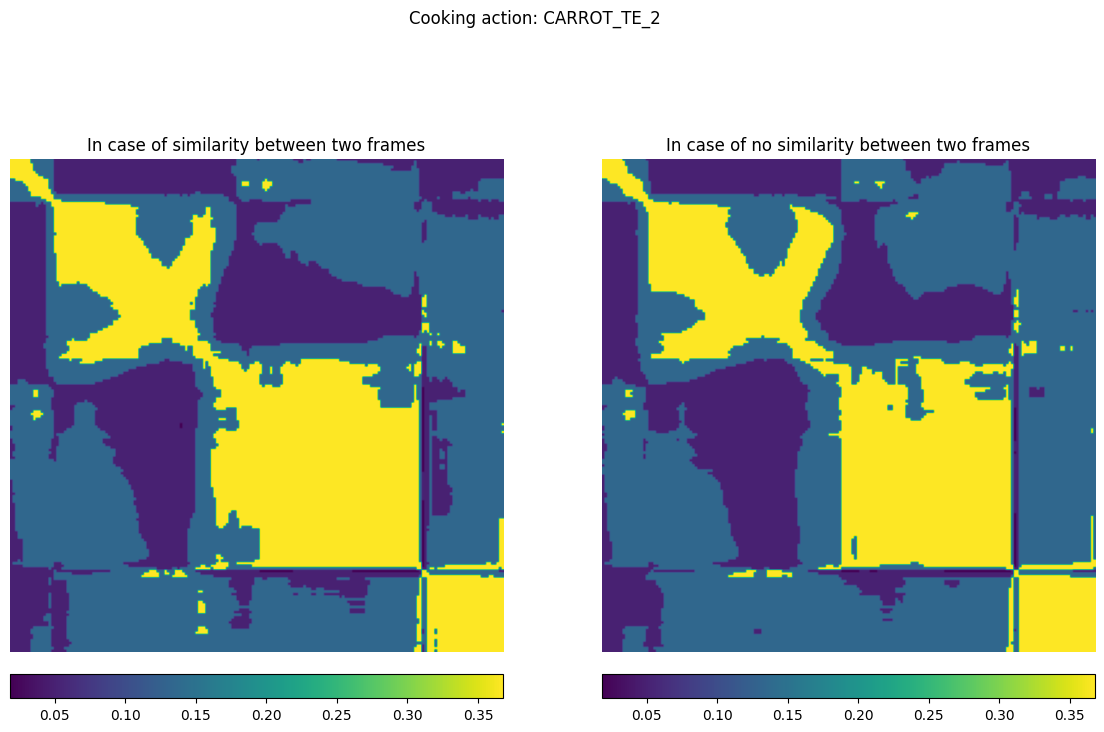

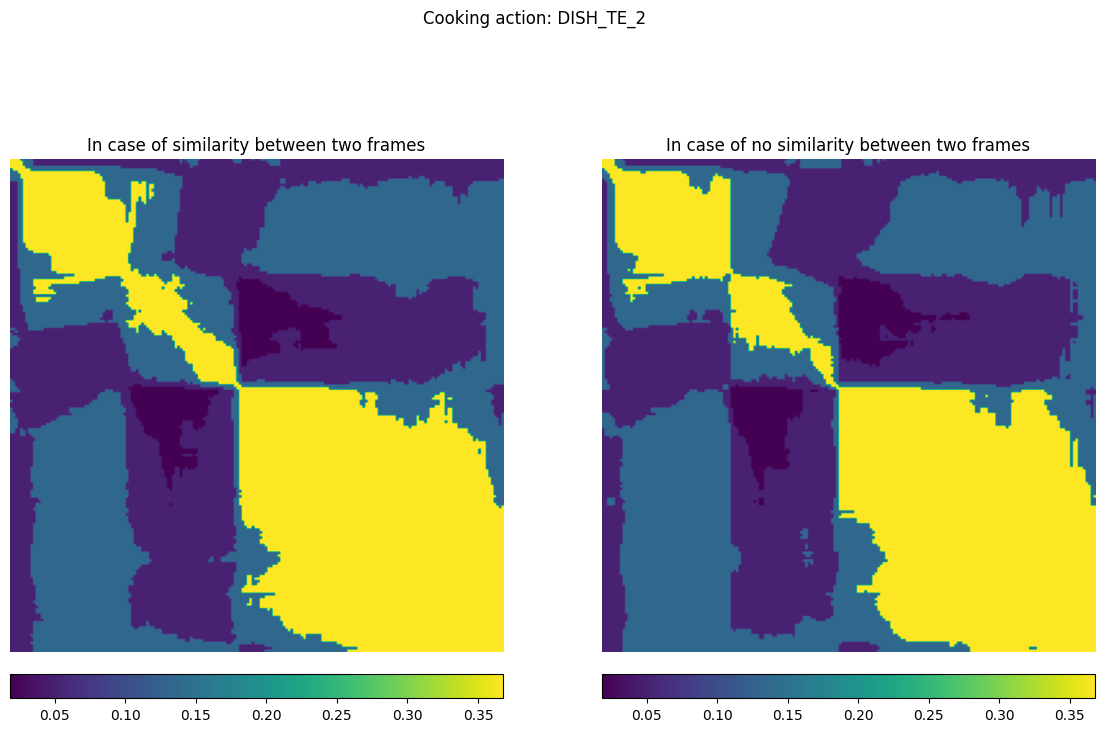

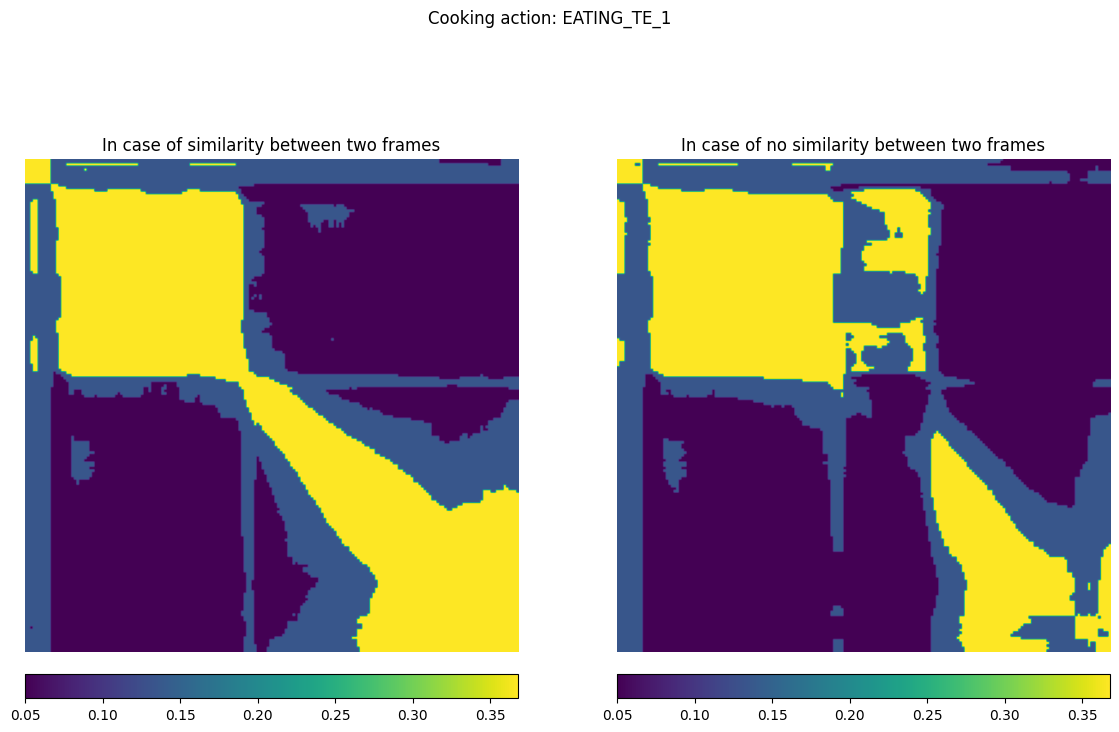

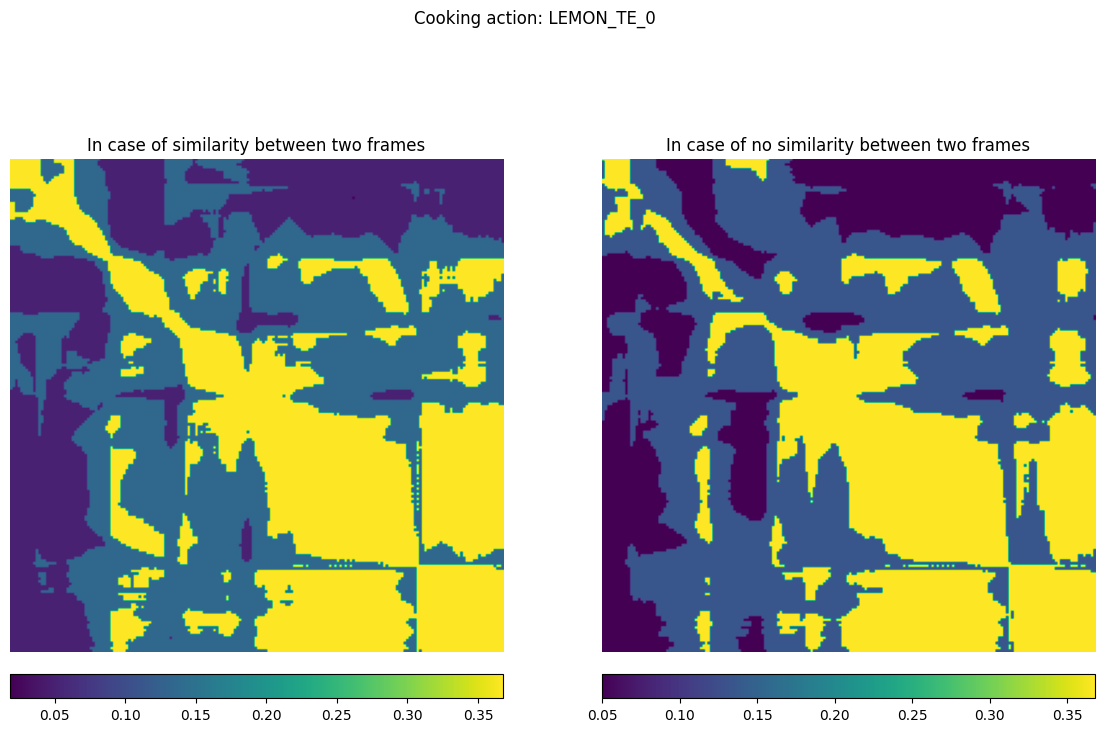

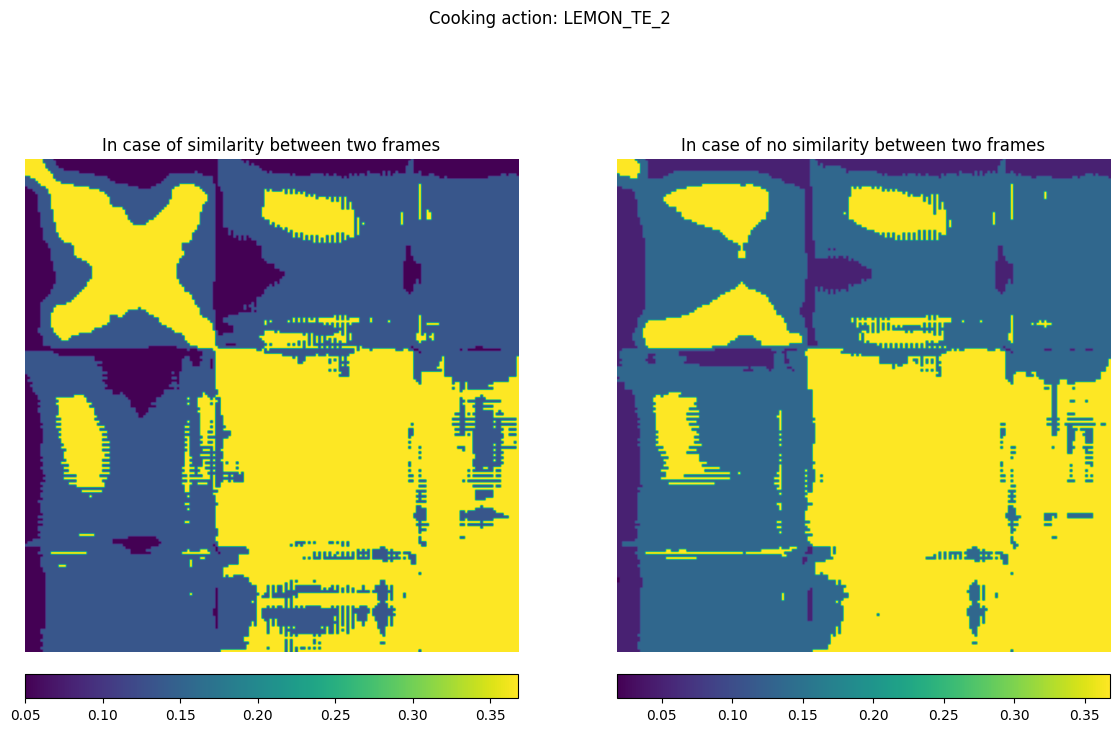

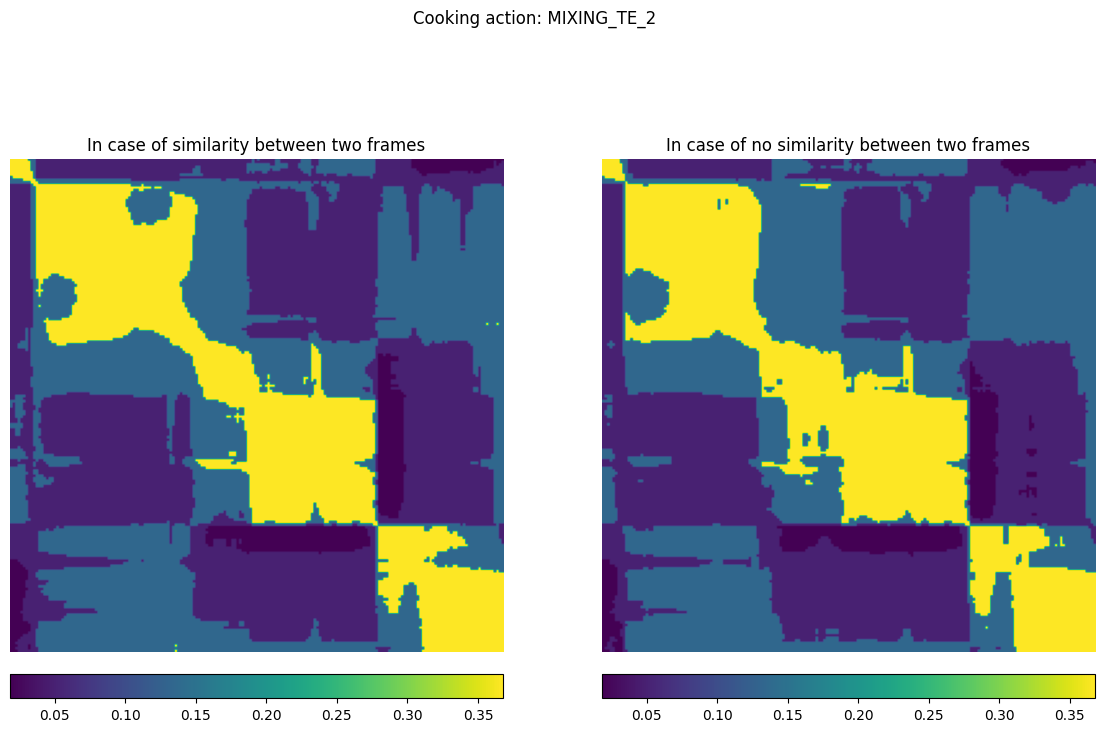

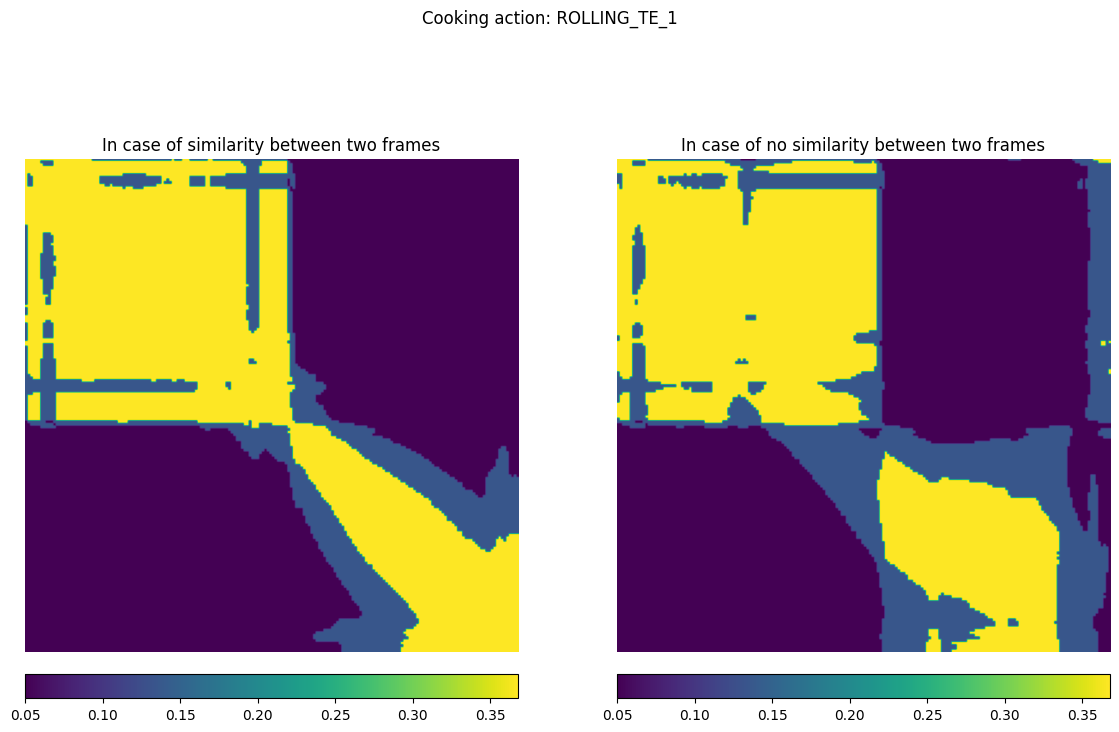

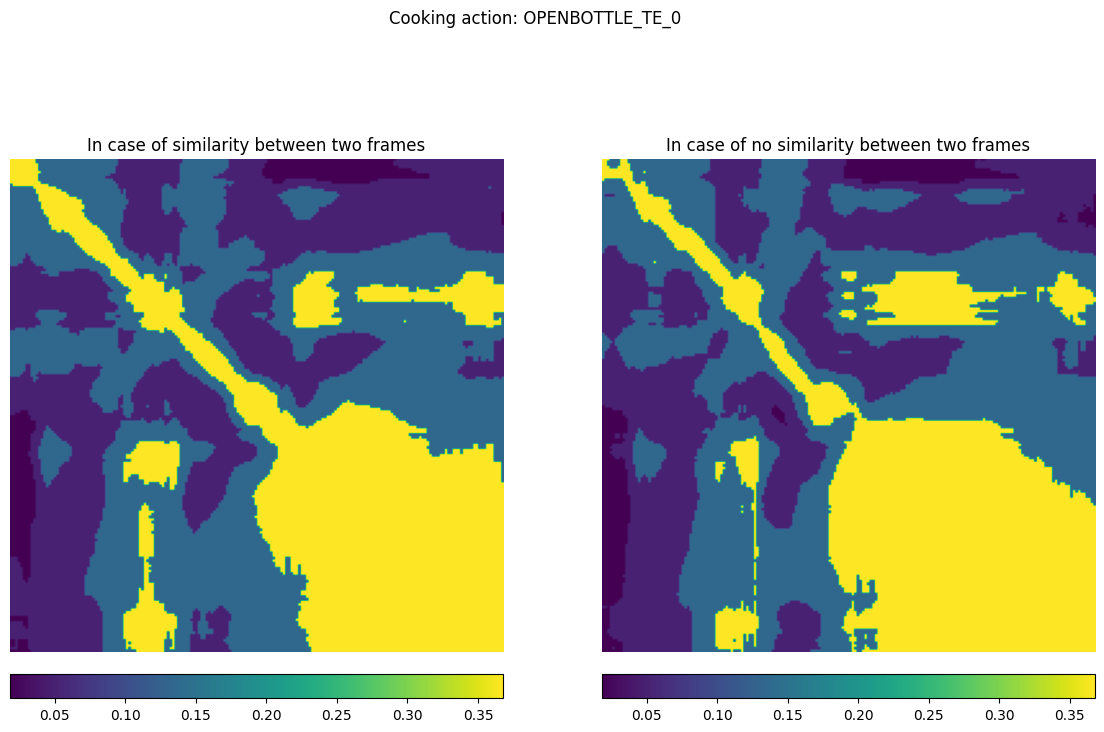

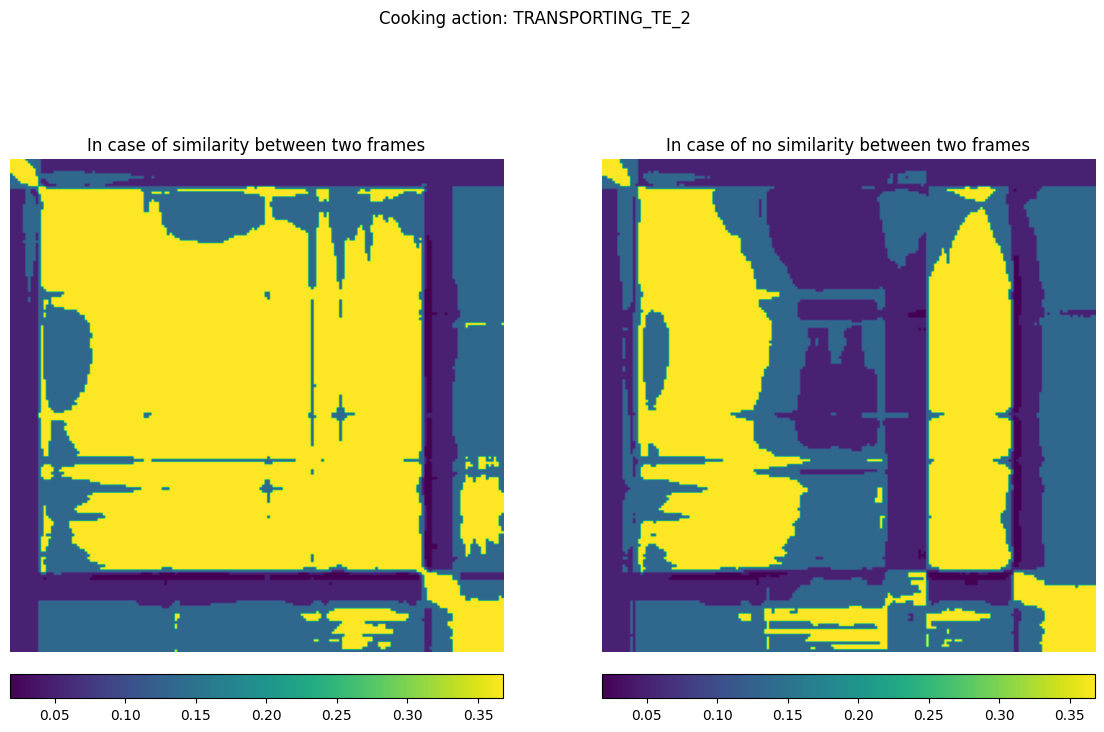

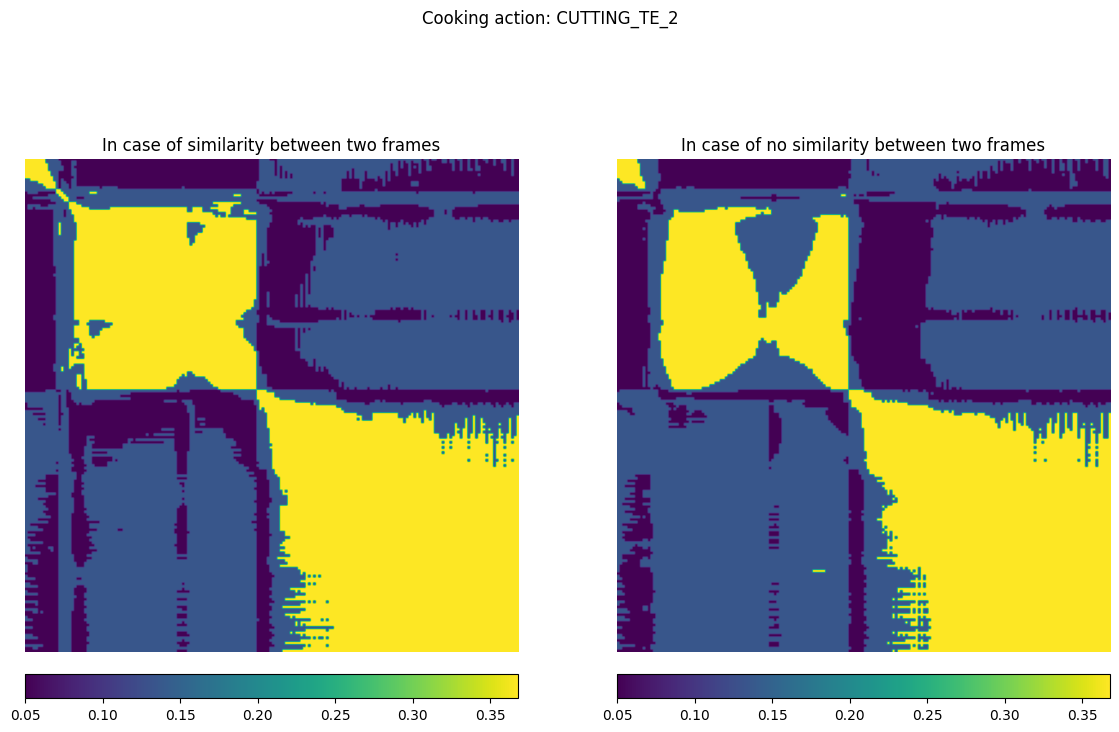

In [11]:
a = 0
for AM in AMs:
    AM1 = AM[0]
    AM2 = AM[1]

    # create figure
    fig = plt.figure(figsize=(14, 14))
    fig.suptitle("Cooking action: "+actions[a], y=0.7)
    a+=1
    
    # setting values to rows and column variables
    rows = 1
    columns = 2

    # Adds a subplot at the 1st position
    fig.add_subplot(rows, columns, 1)

    # showing affinity matrix
    plt.imshow(AM1)
    plt.axis('off')
    plt.colorbar(orientation="horizontal",pad=0.02)
    plt.title("In case of similarity between two frames")

    # Adds a subplot at the 2nd position
    fig.add_subplot(rows, columns, 2)

    # showing affinity matrix
    plt.imshow(AM2)
    plt.axis('off')
    plt.colorbar(orientation="horizontal",pad=0.02)
    plt.title("In case of no similarity between two frames")


We notice that in case of similarity between two frames, the values are higher in the diagonal of the affinity matrix compared to the one in case of no similarity. This demonstrates the fact that similar segments of frames will show up as a path of high similarity along diagonals of the affinity matrix.

### Results

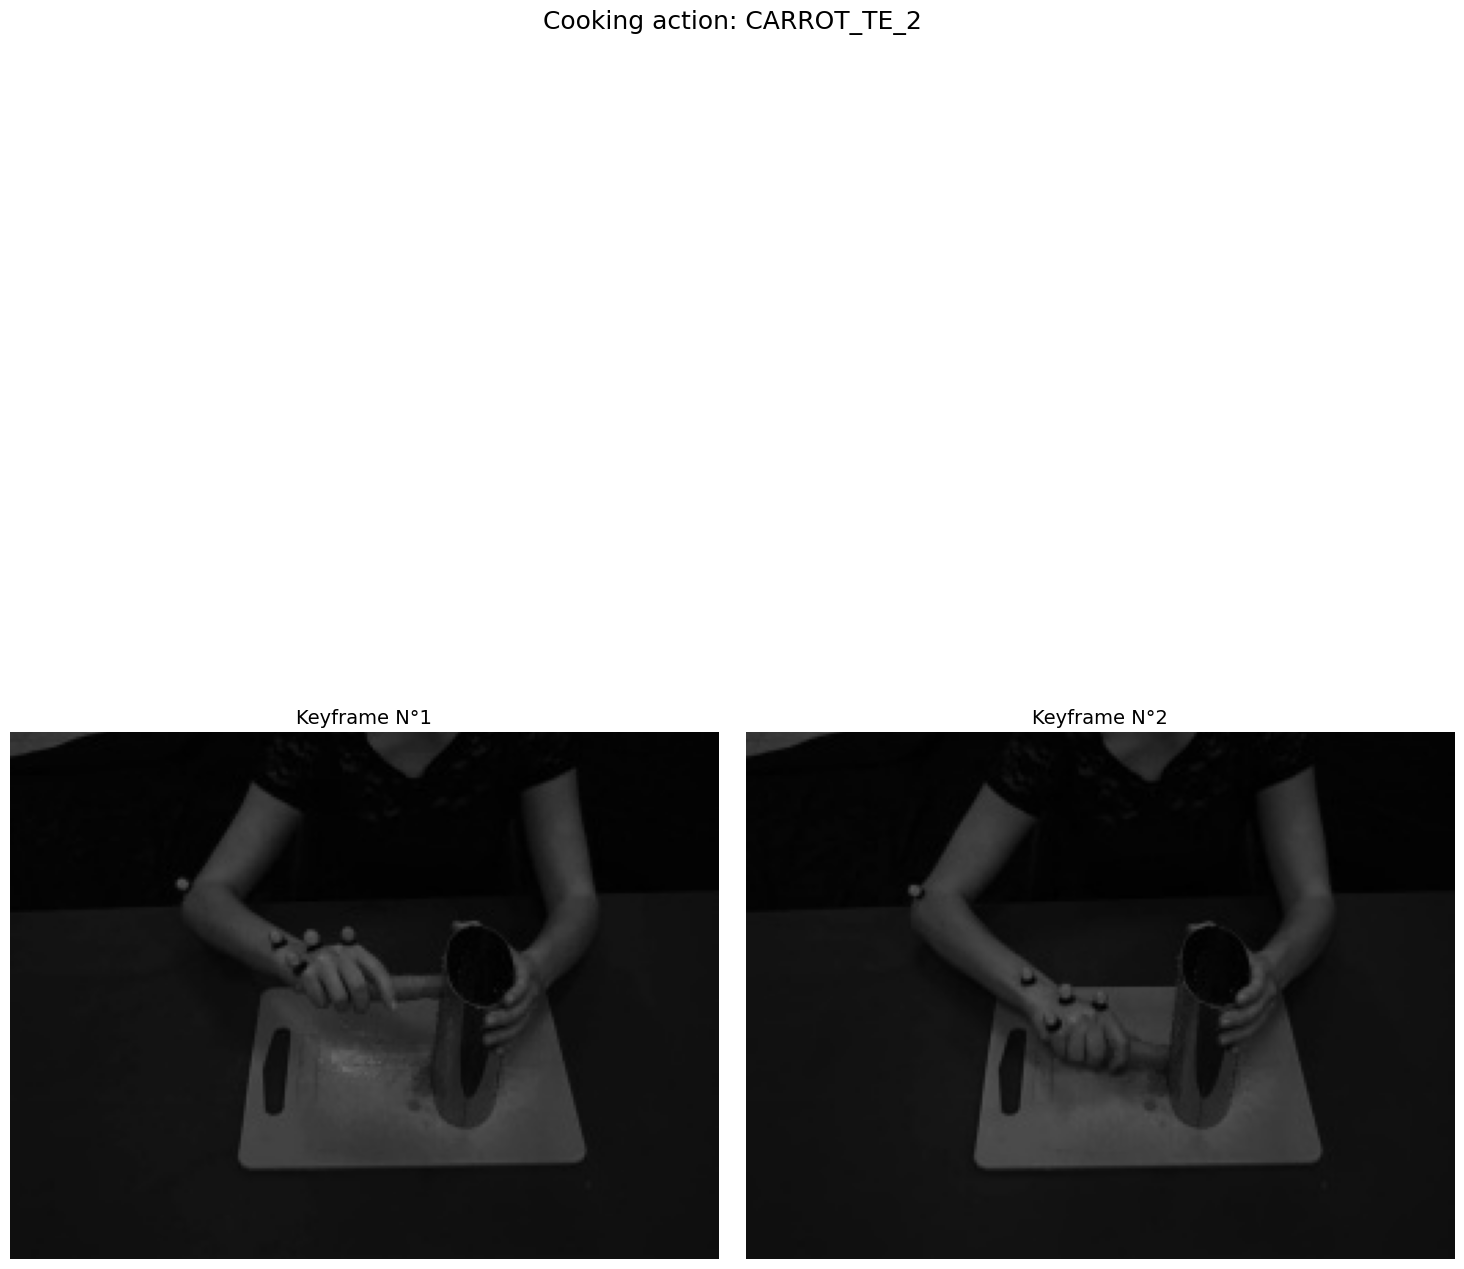

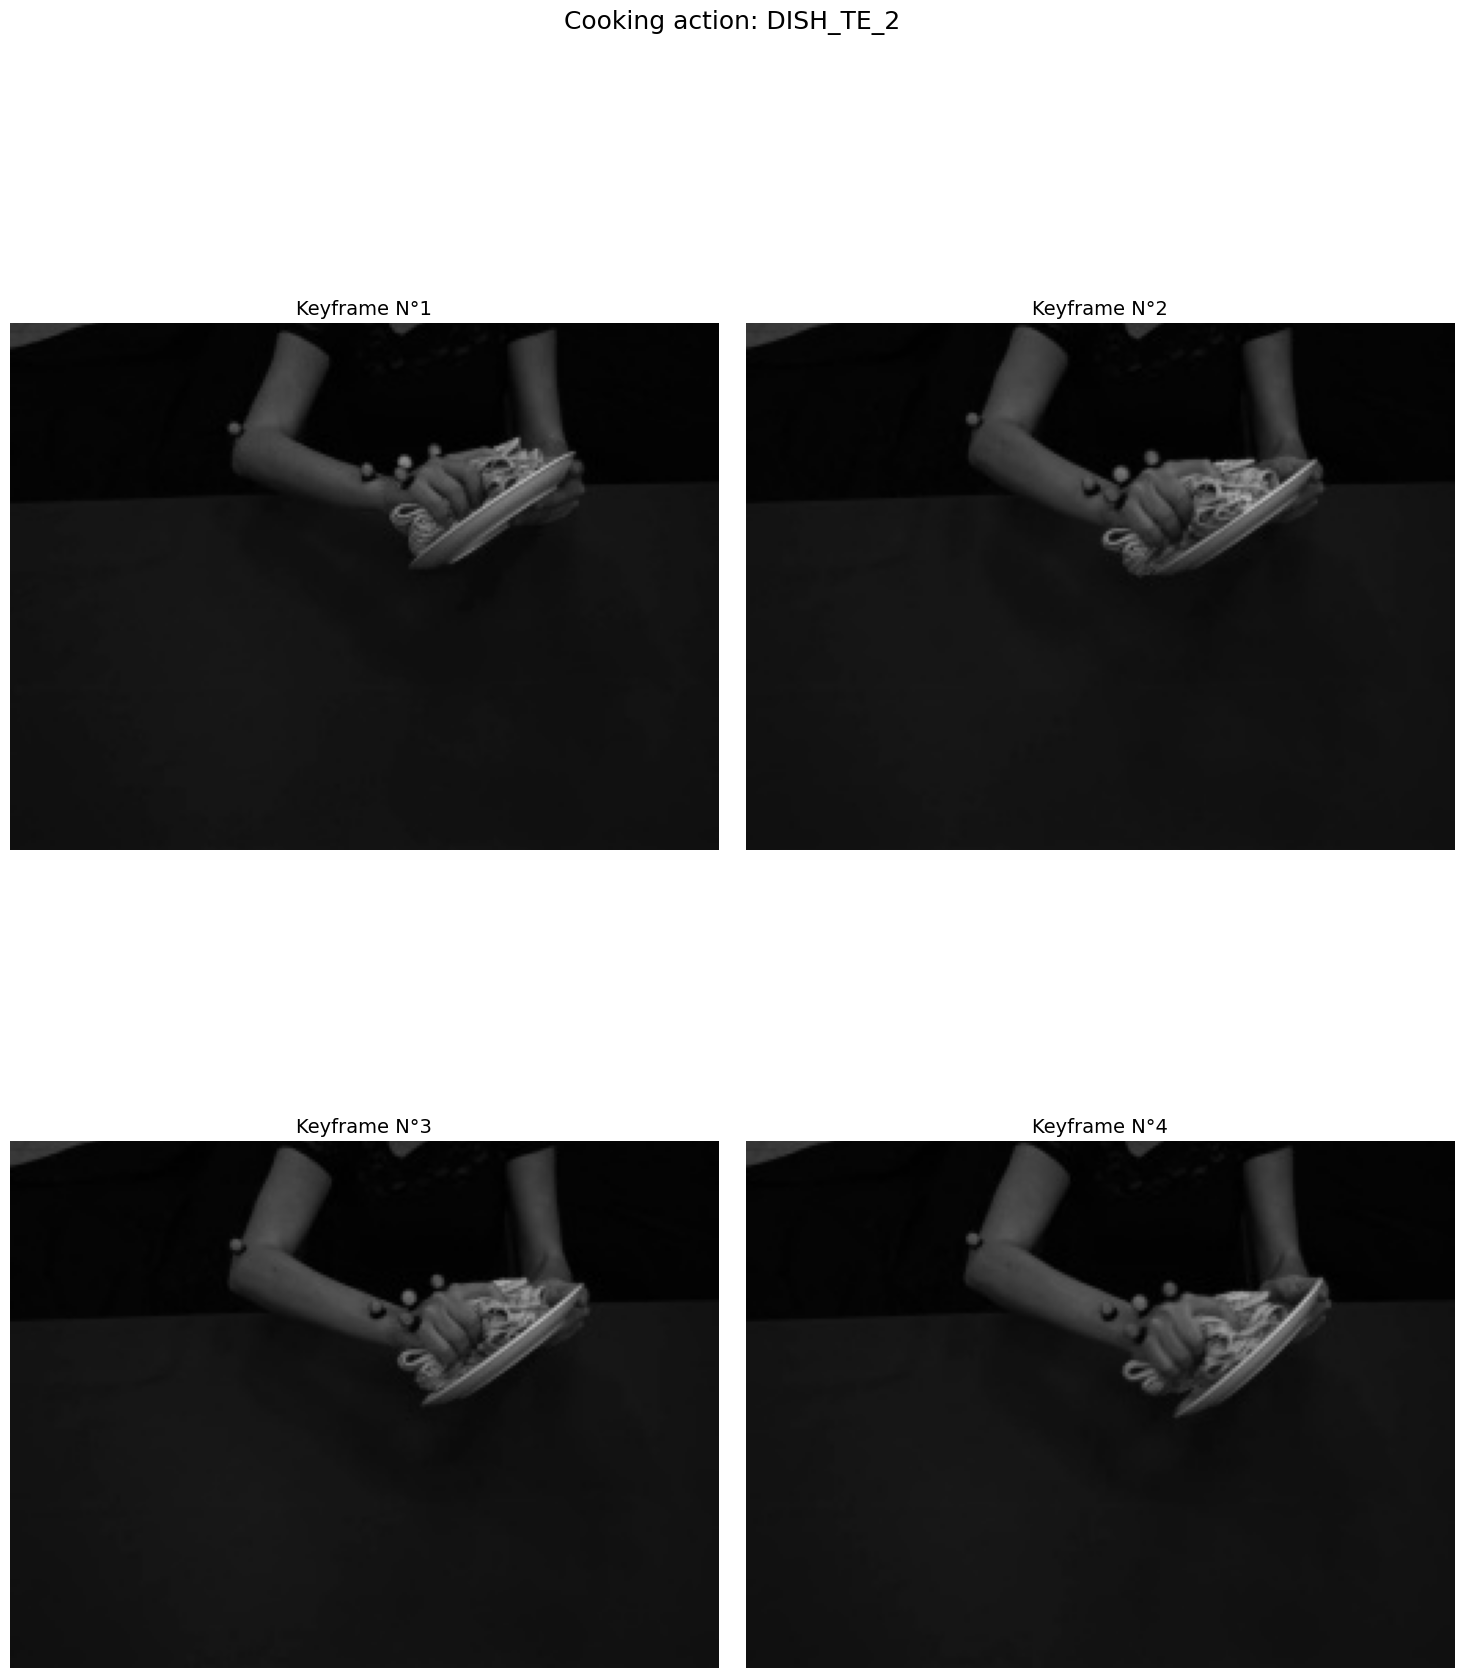

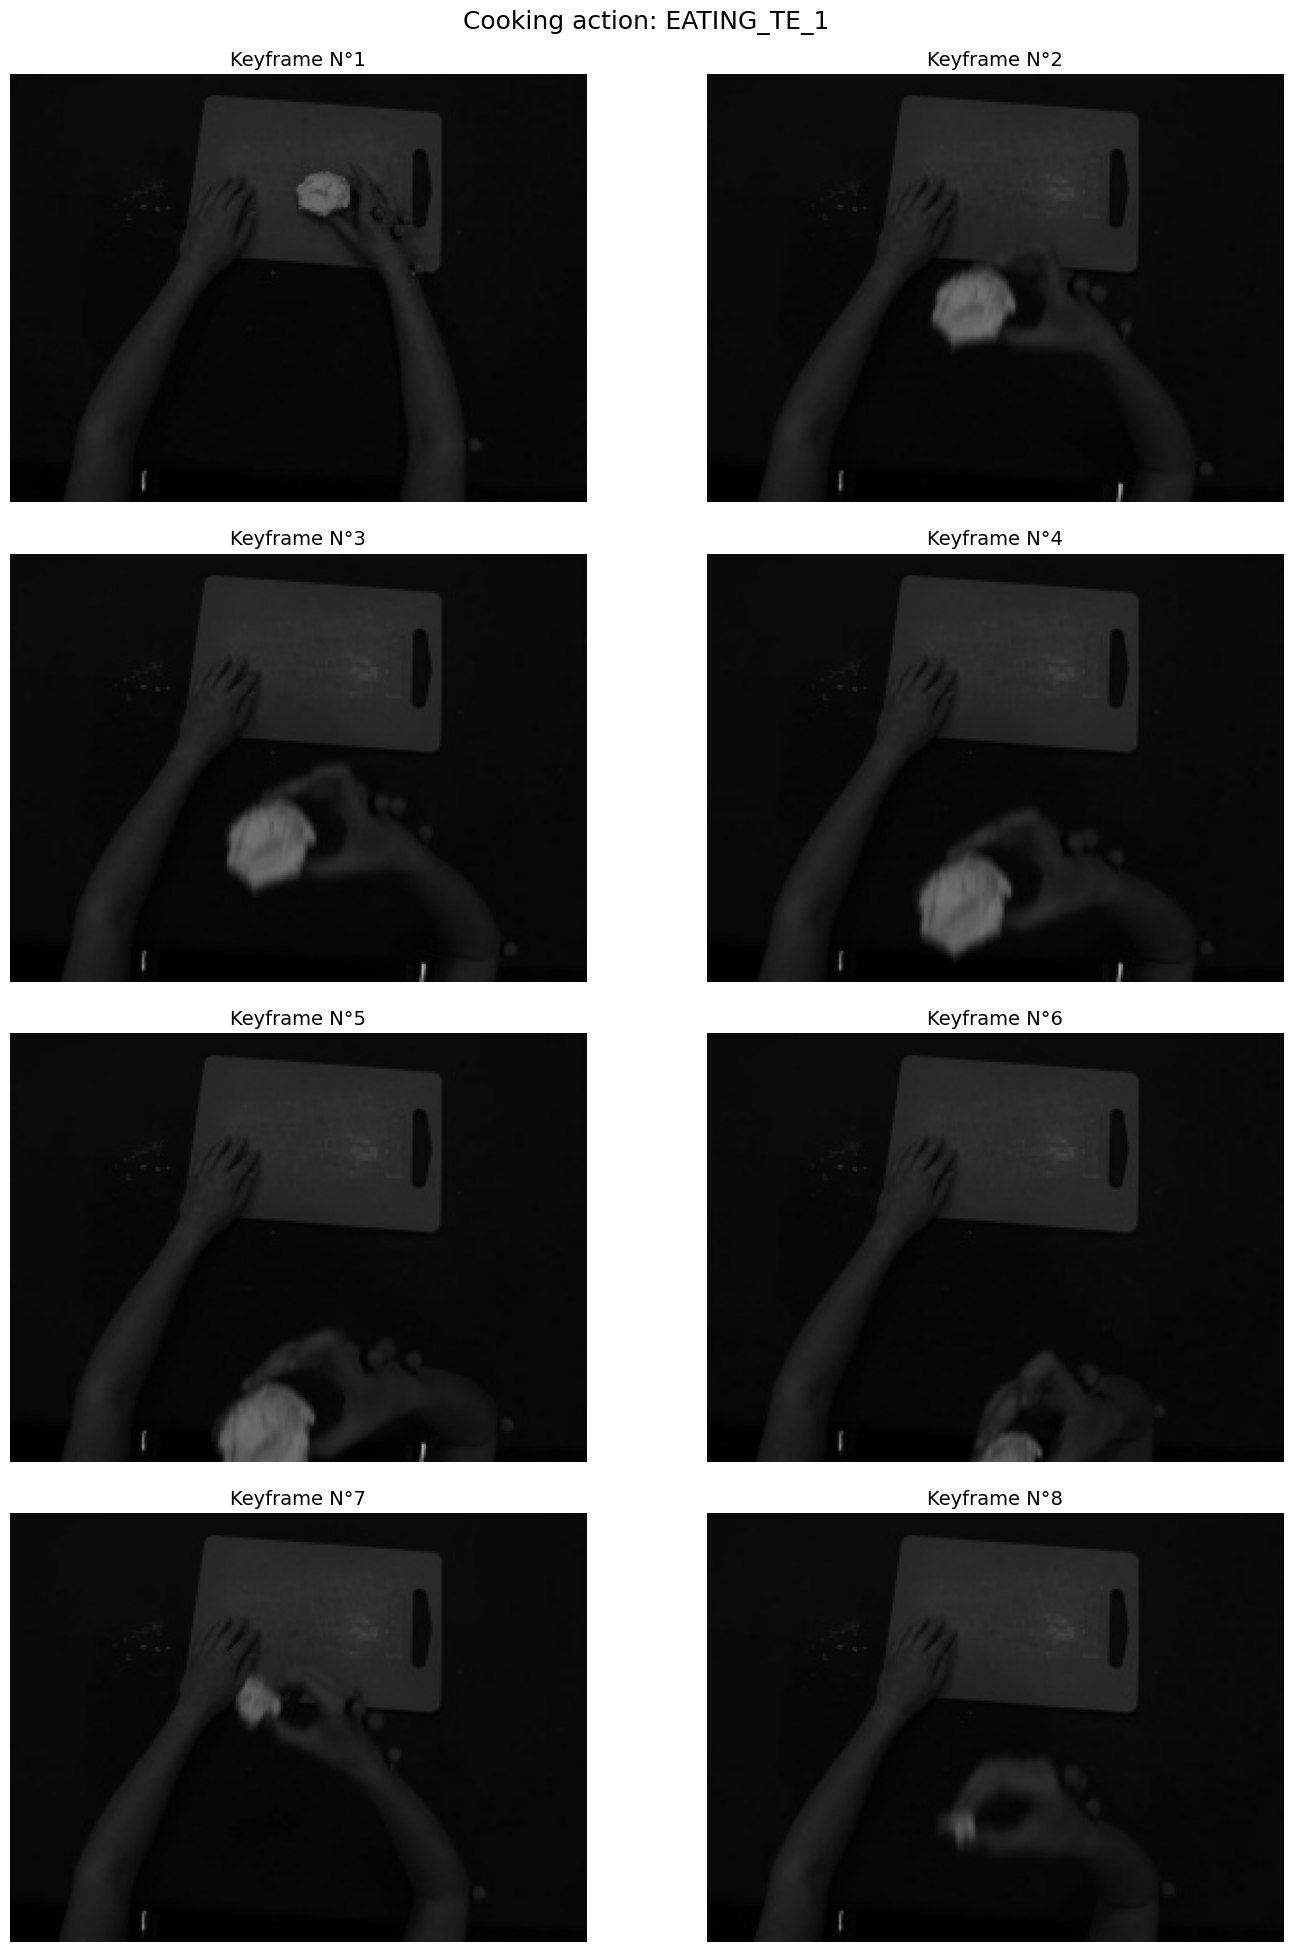

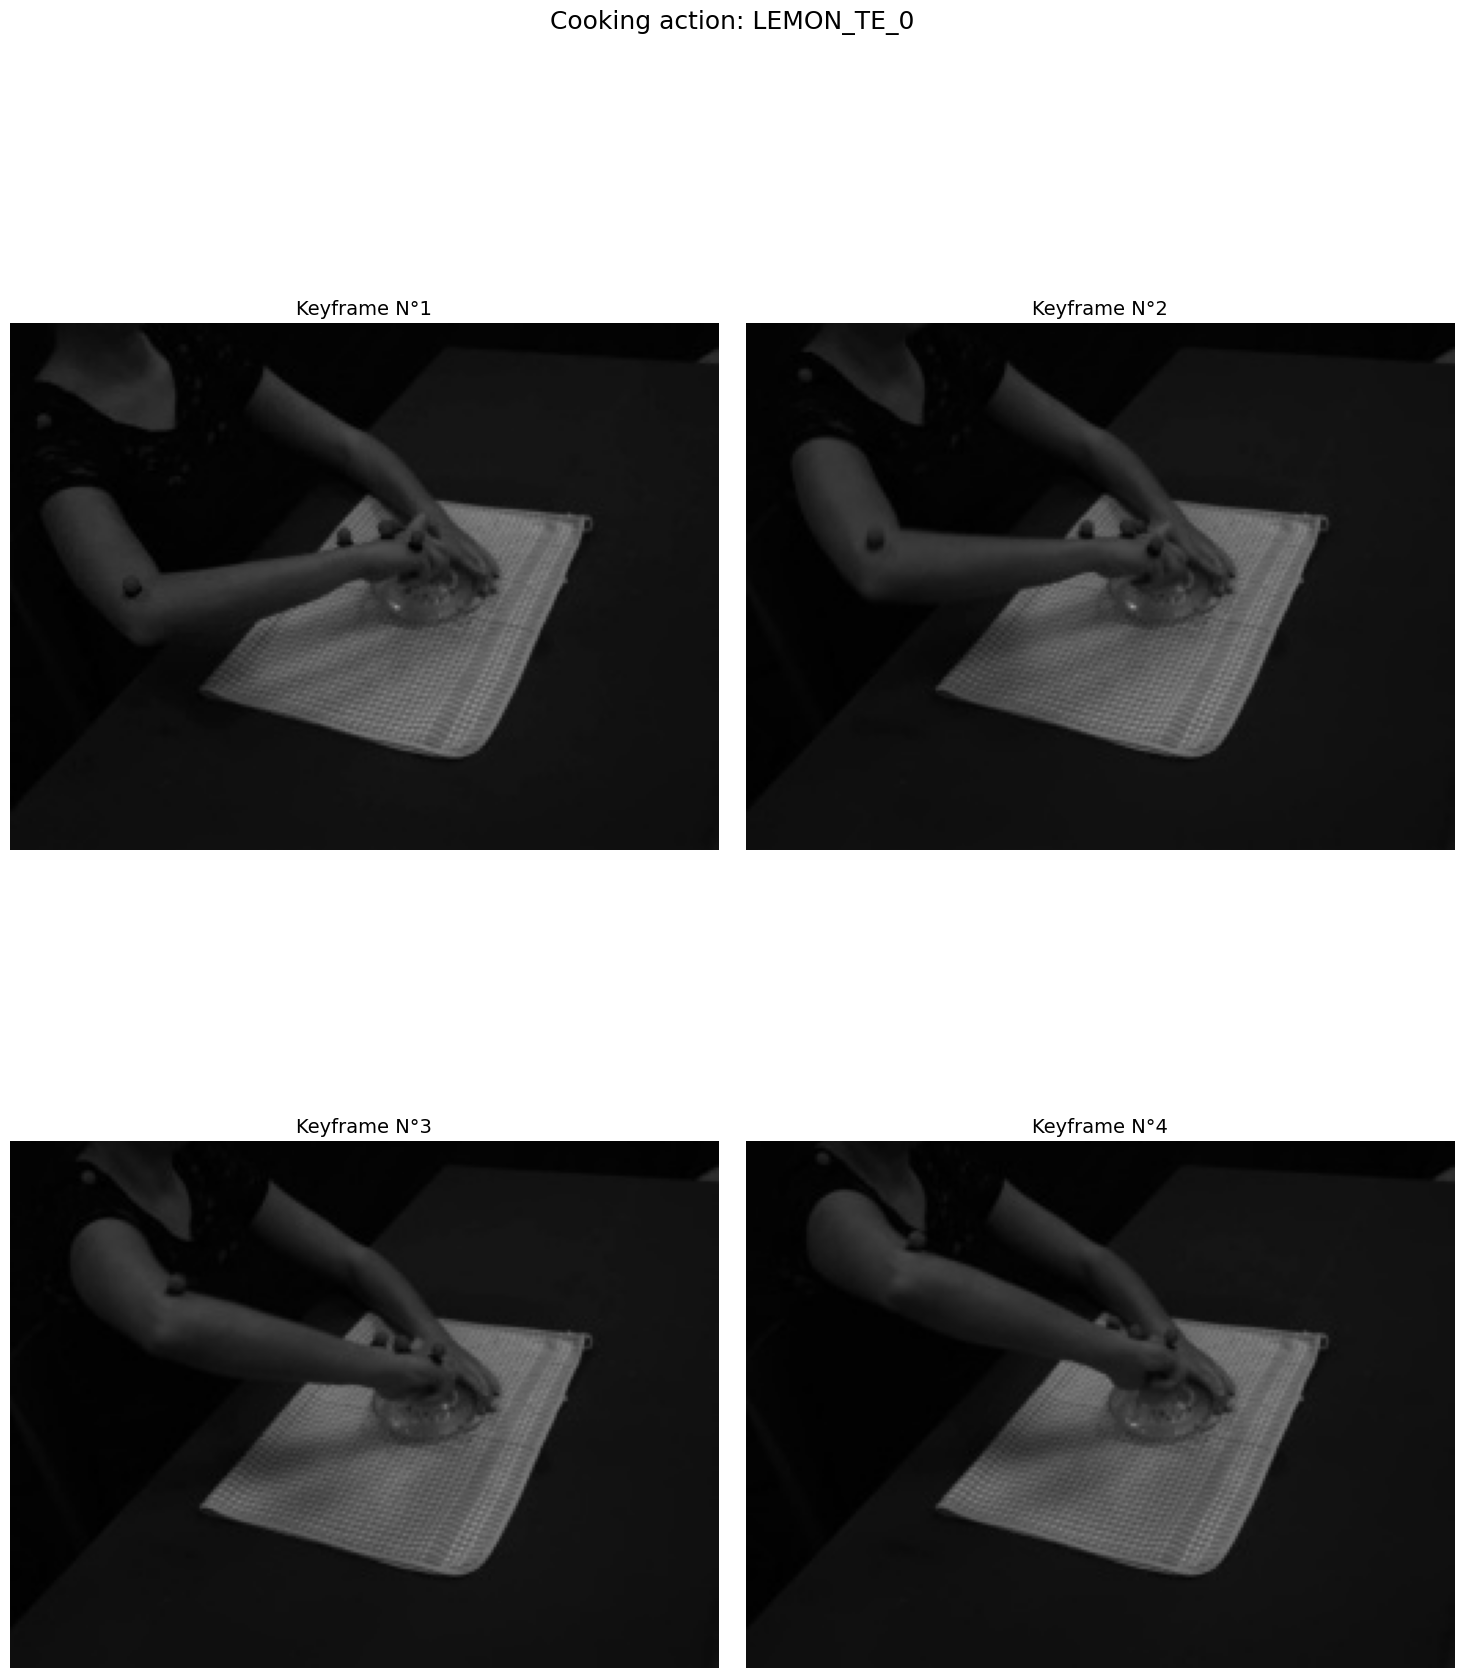

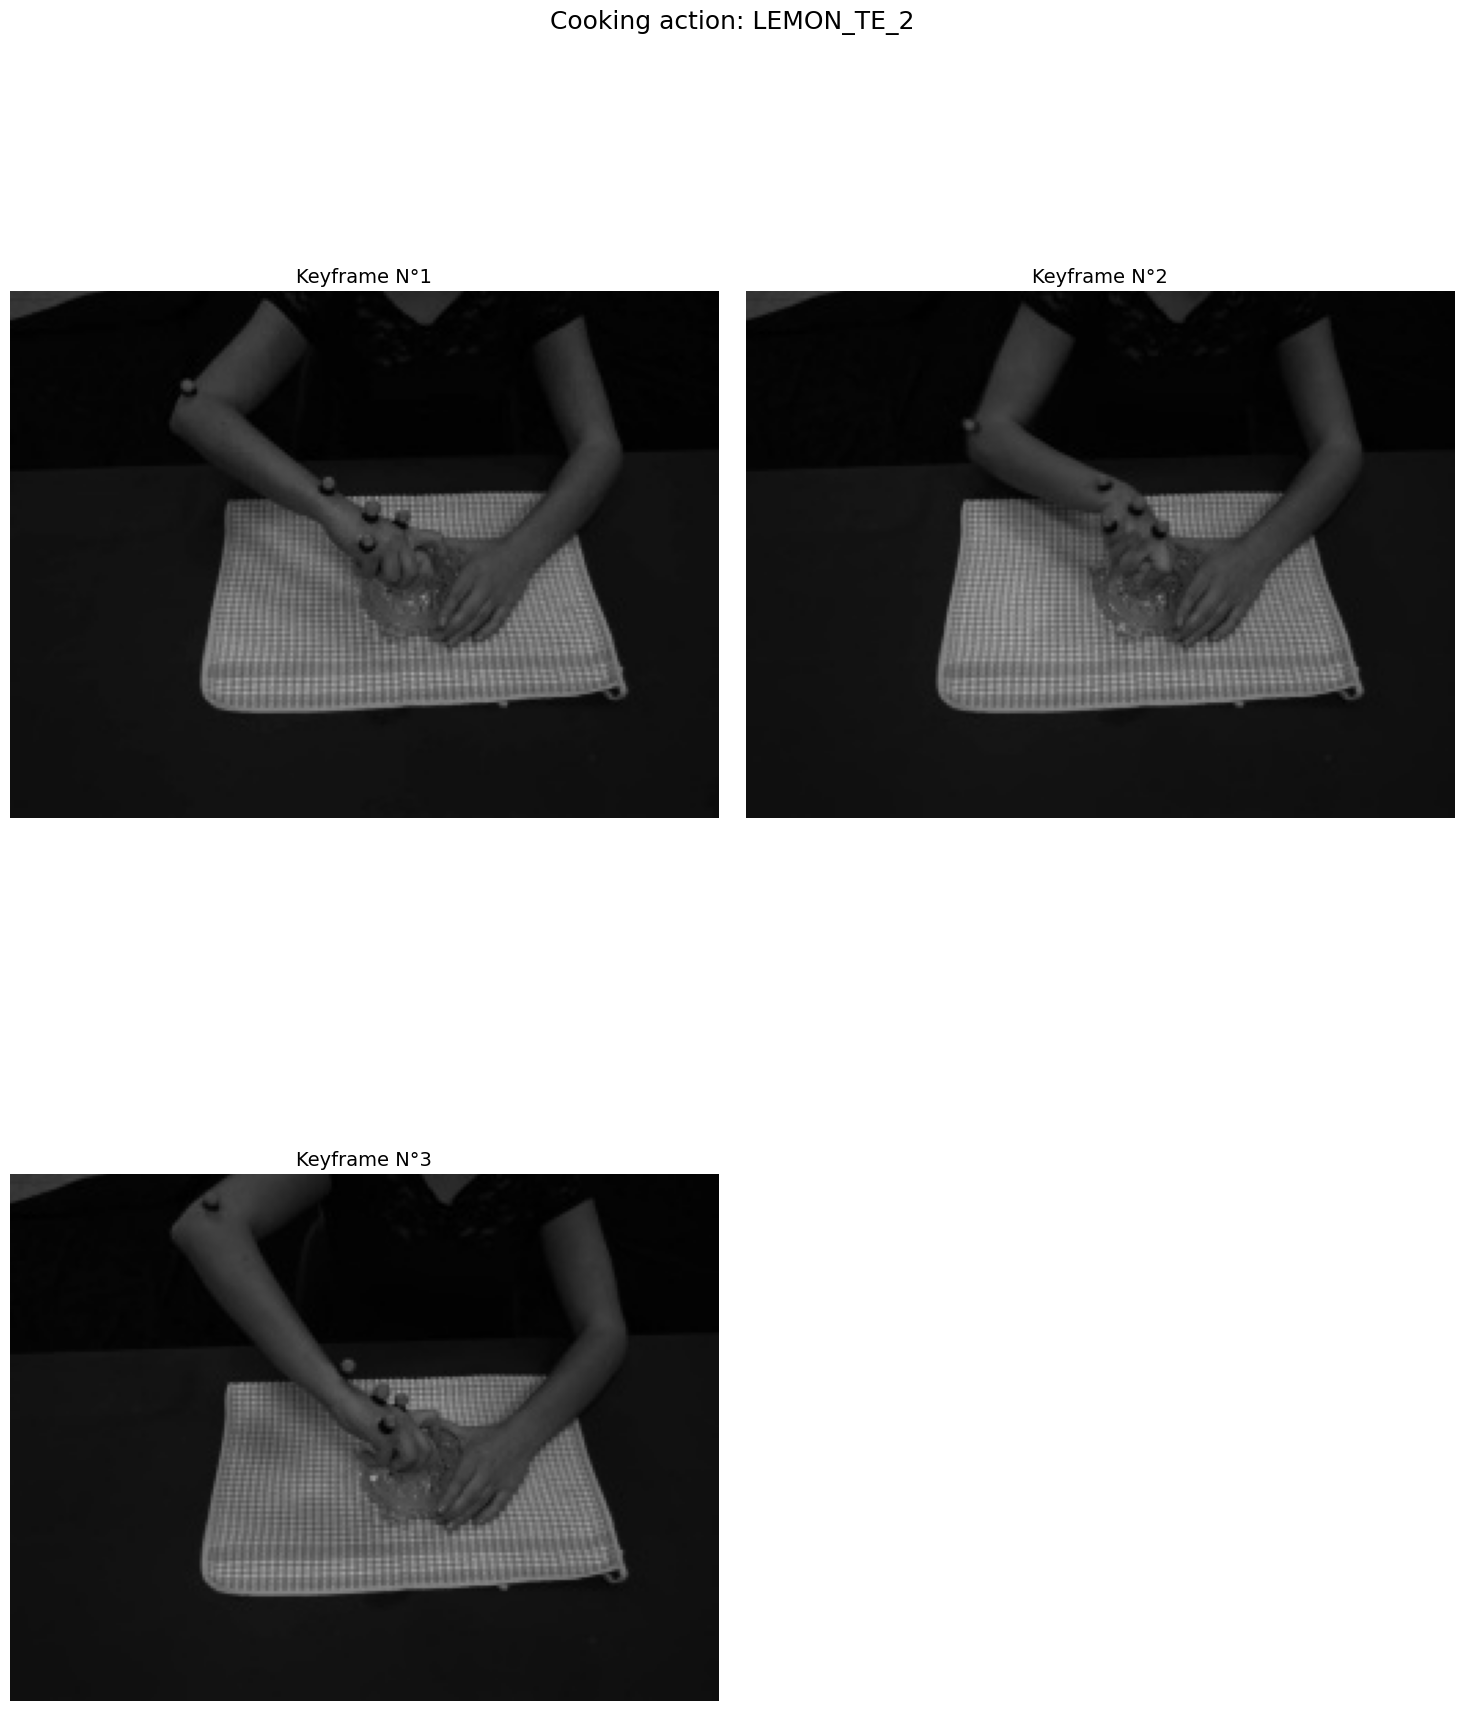

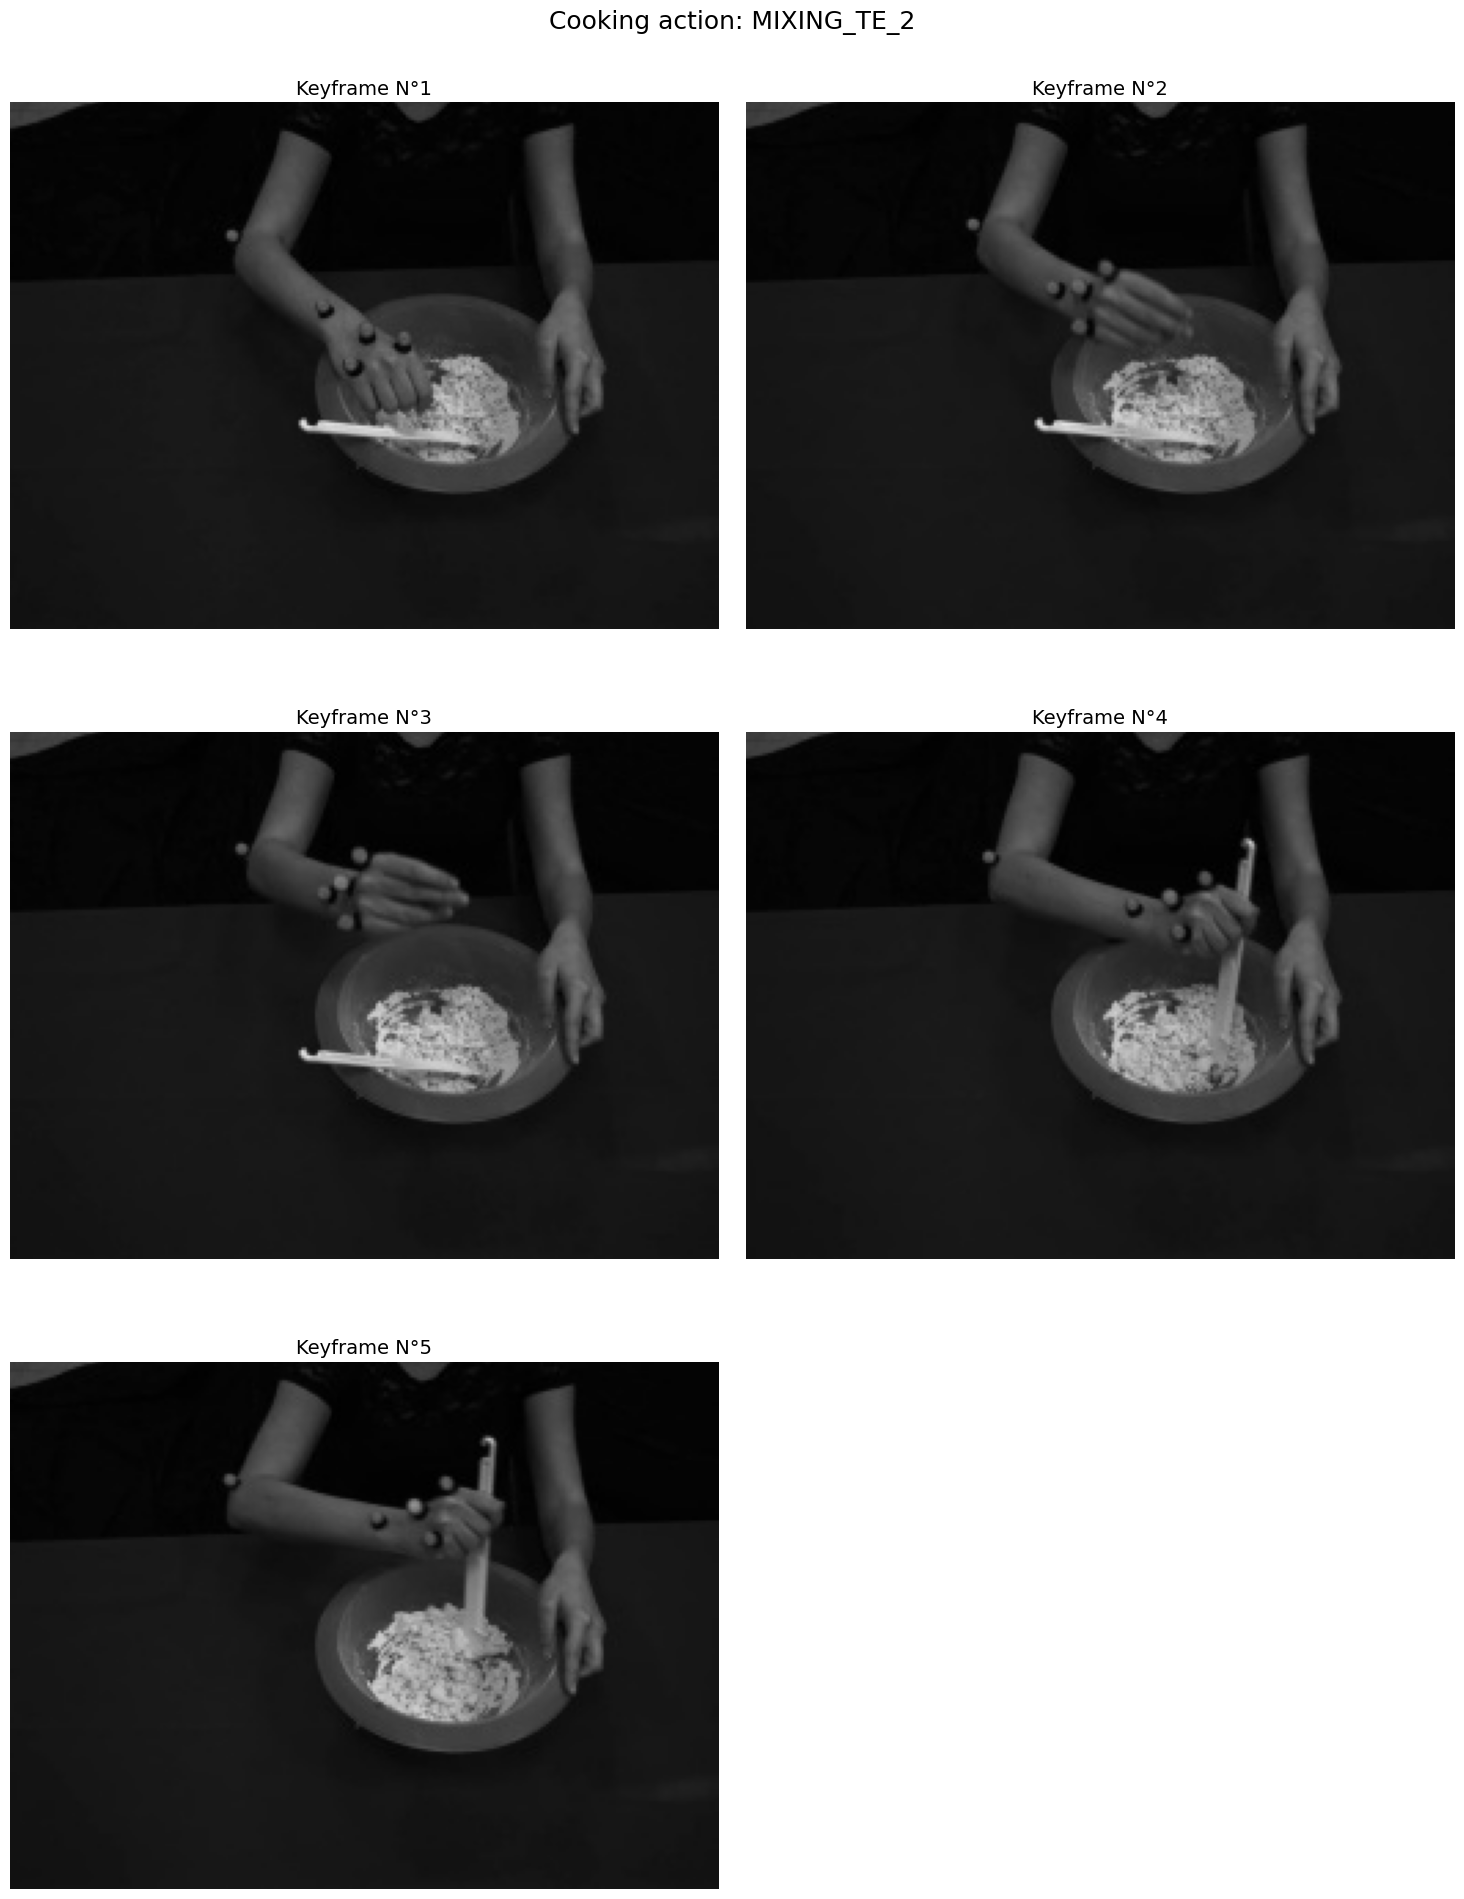

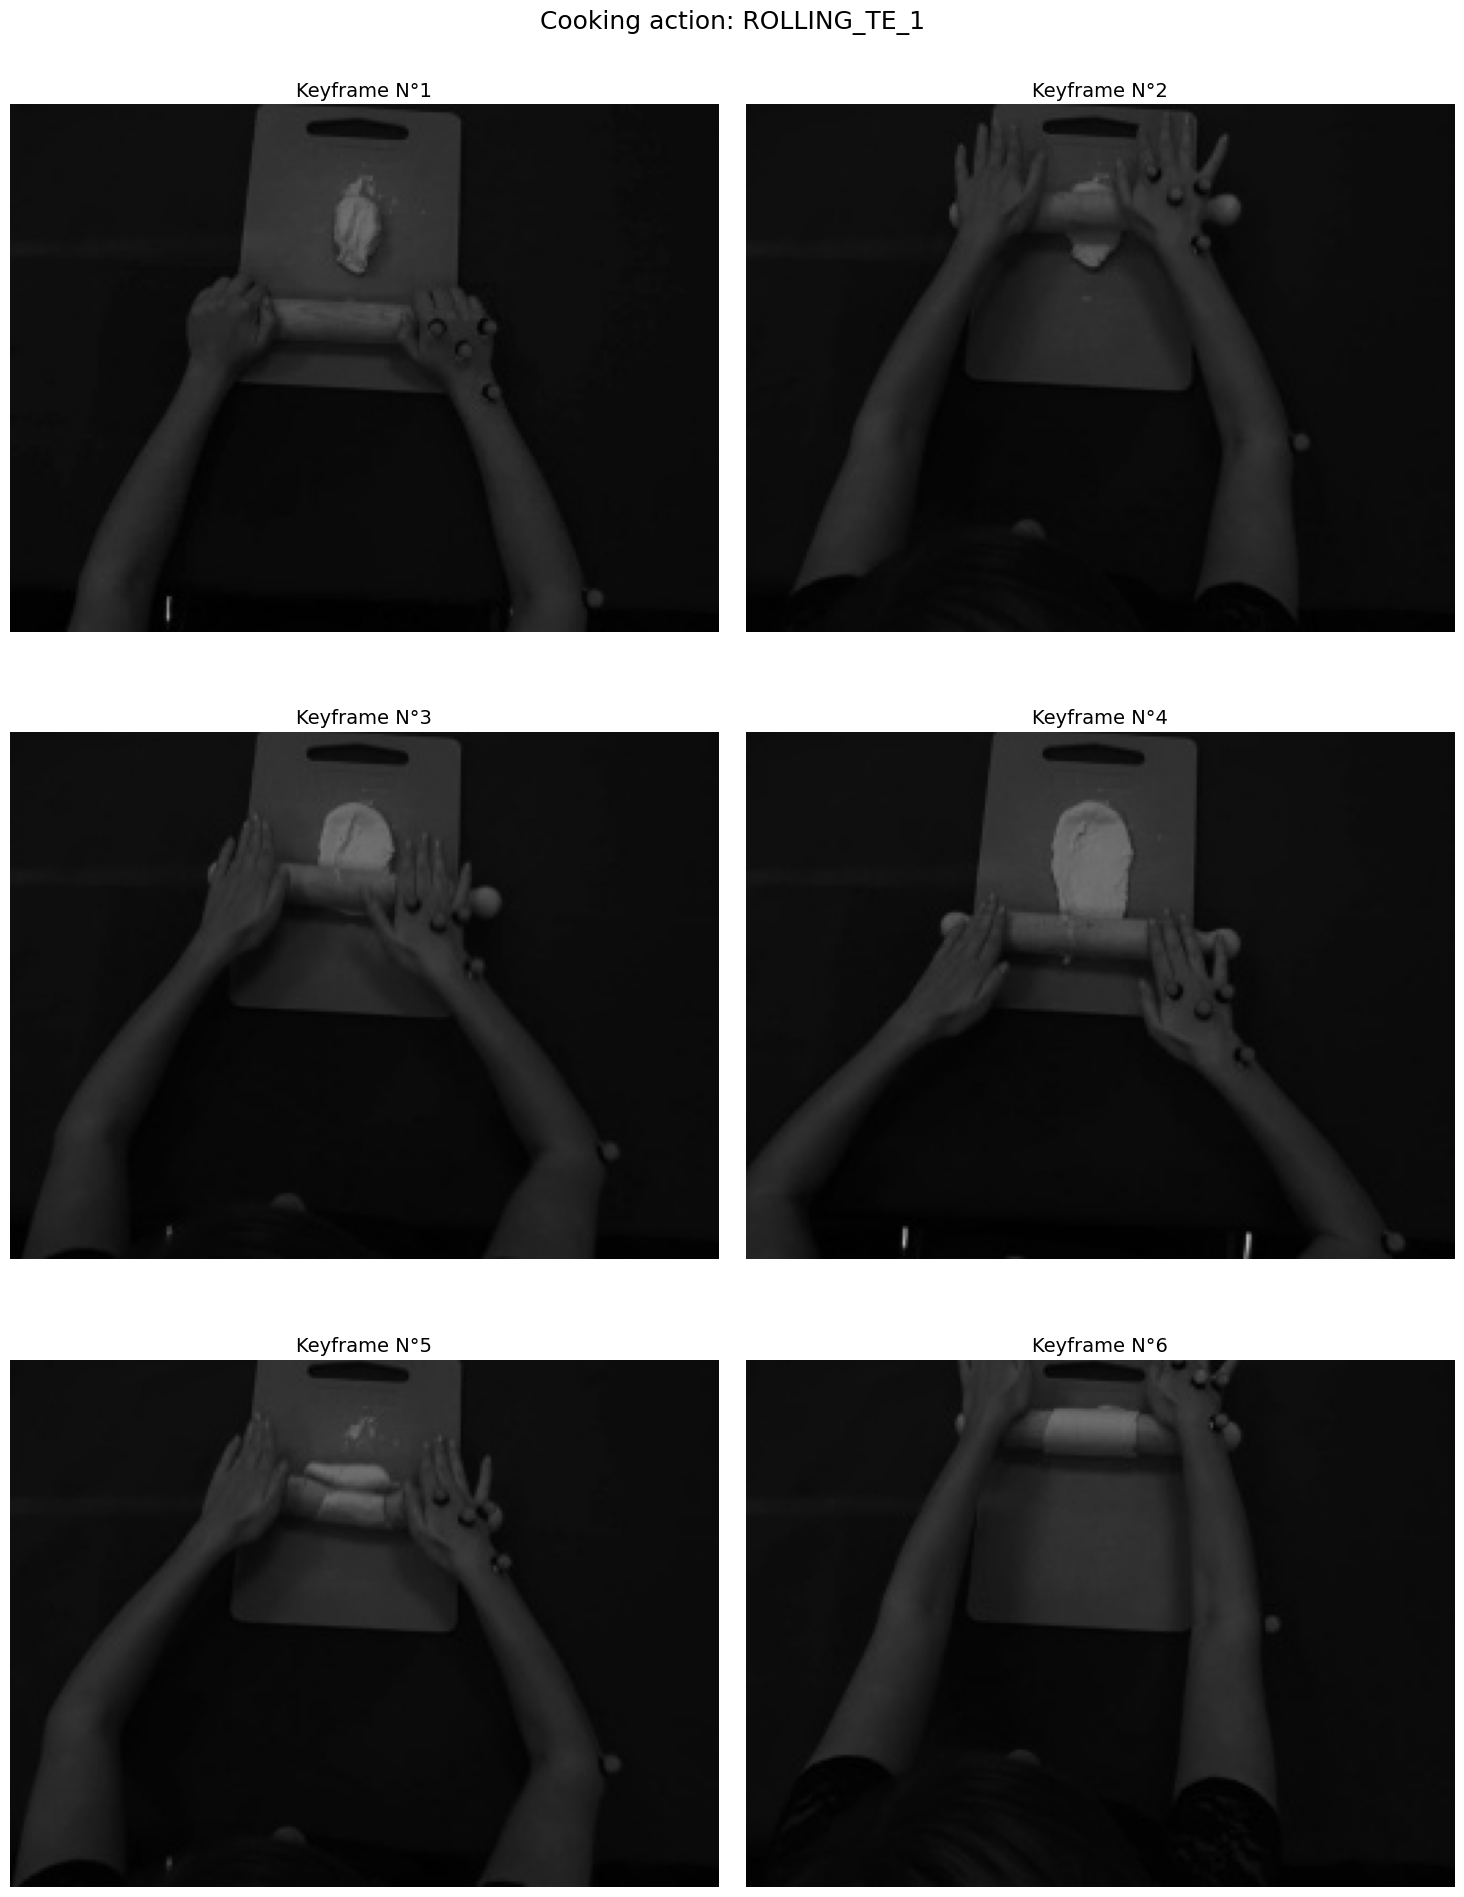

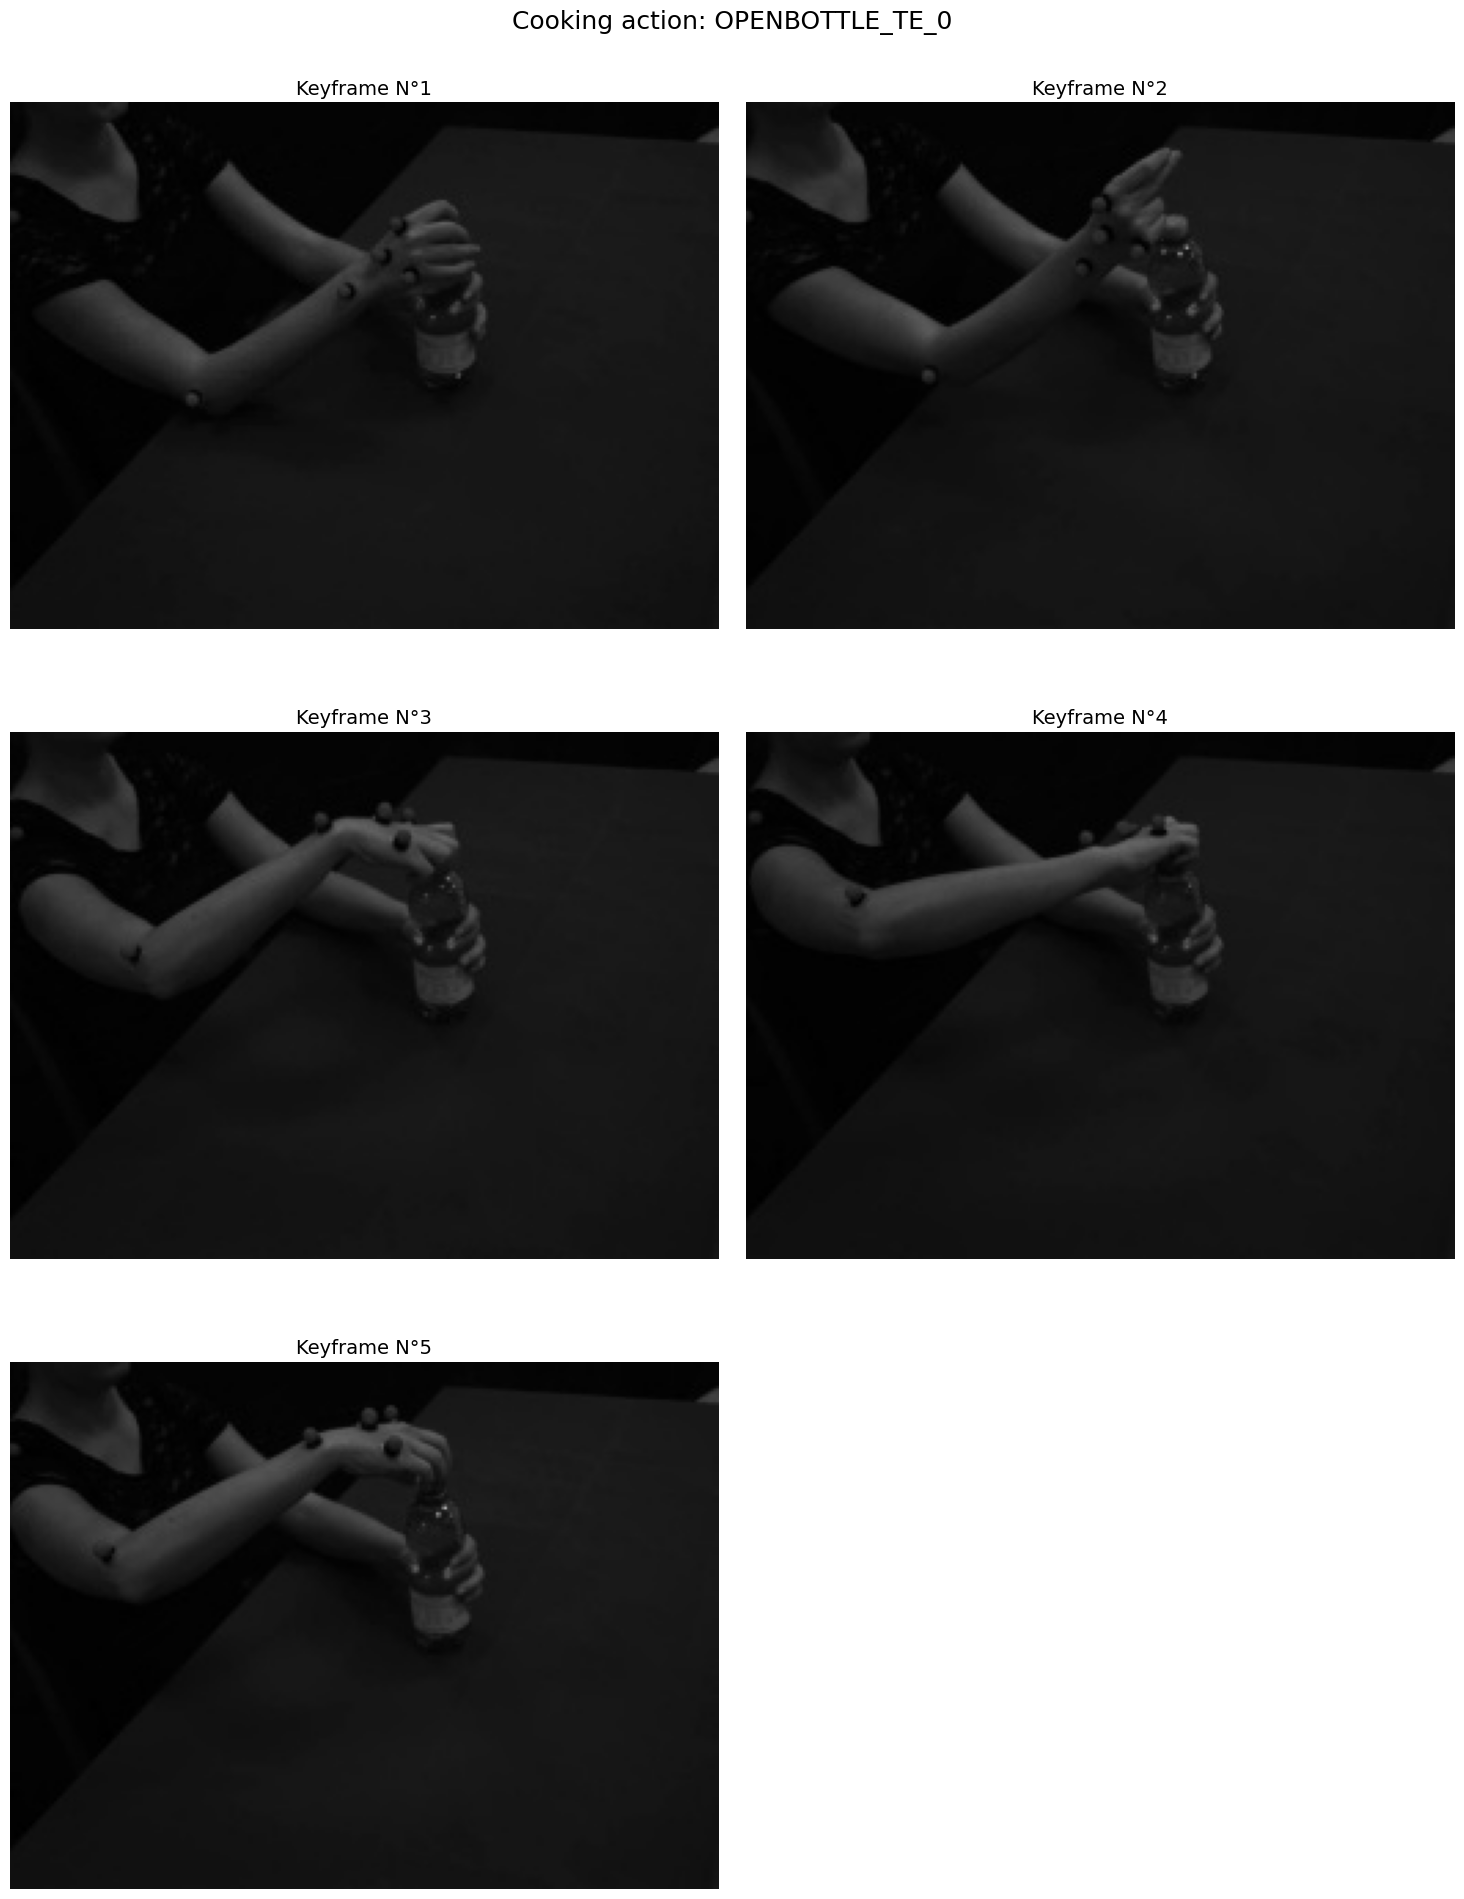

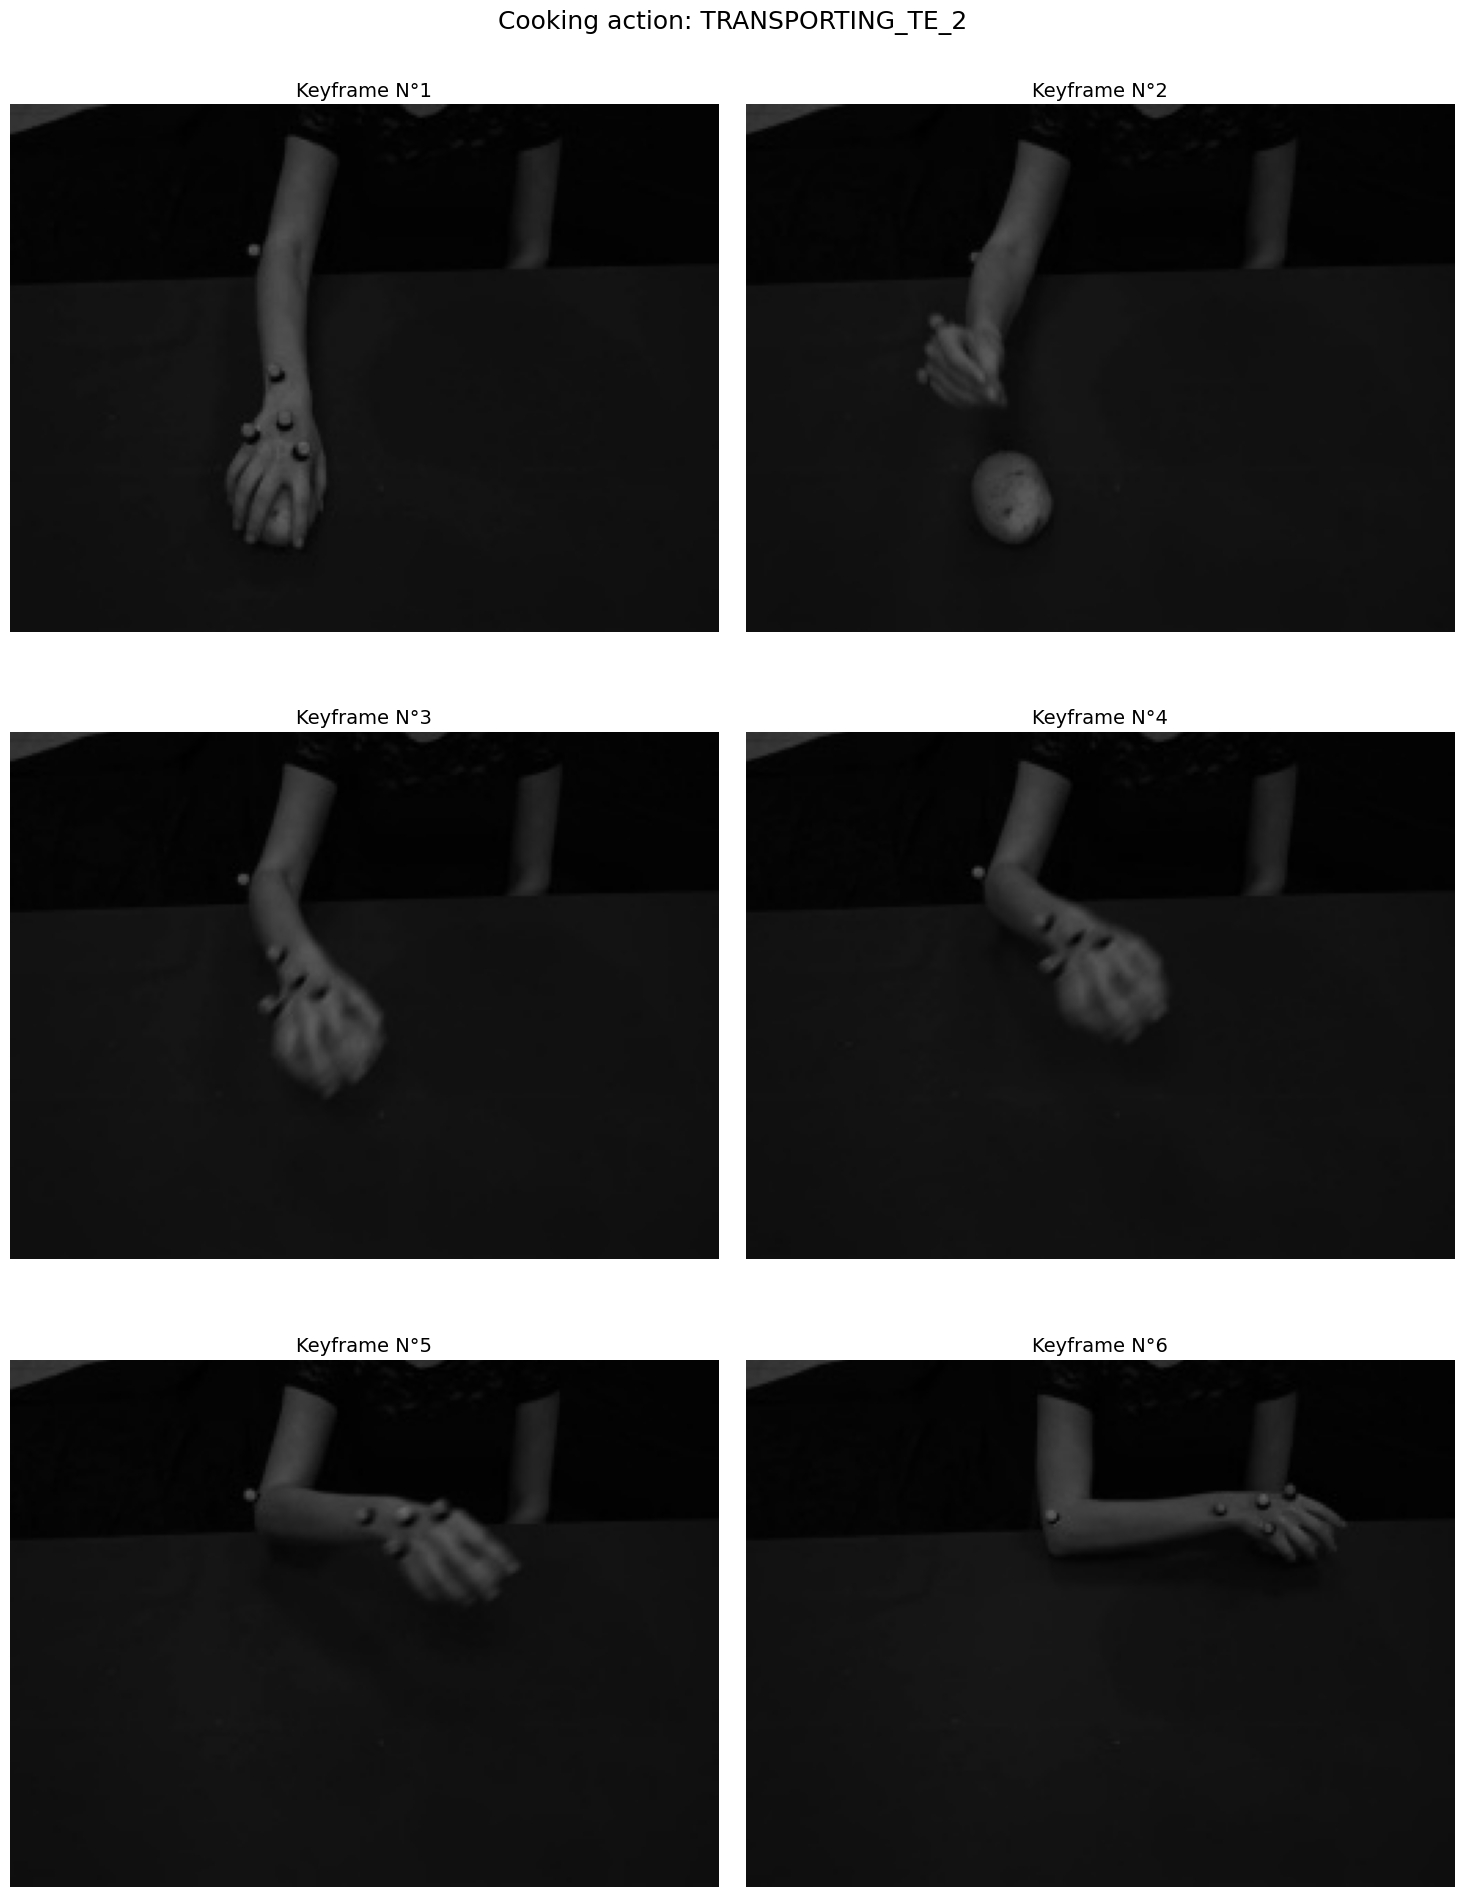

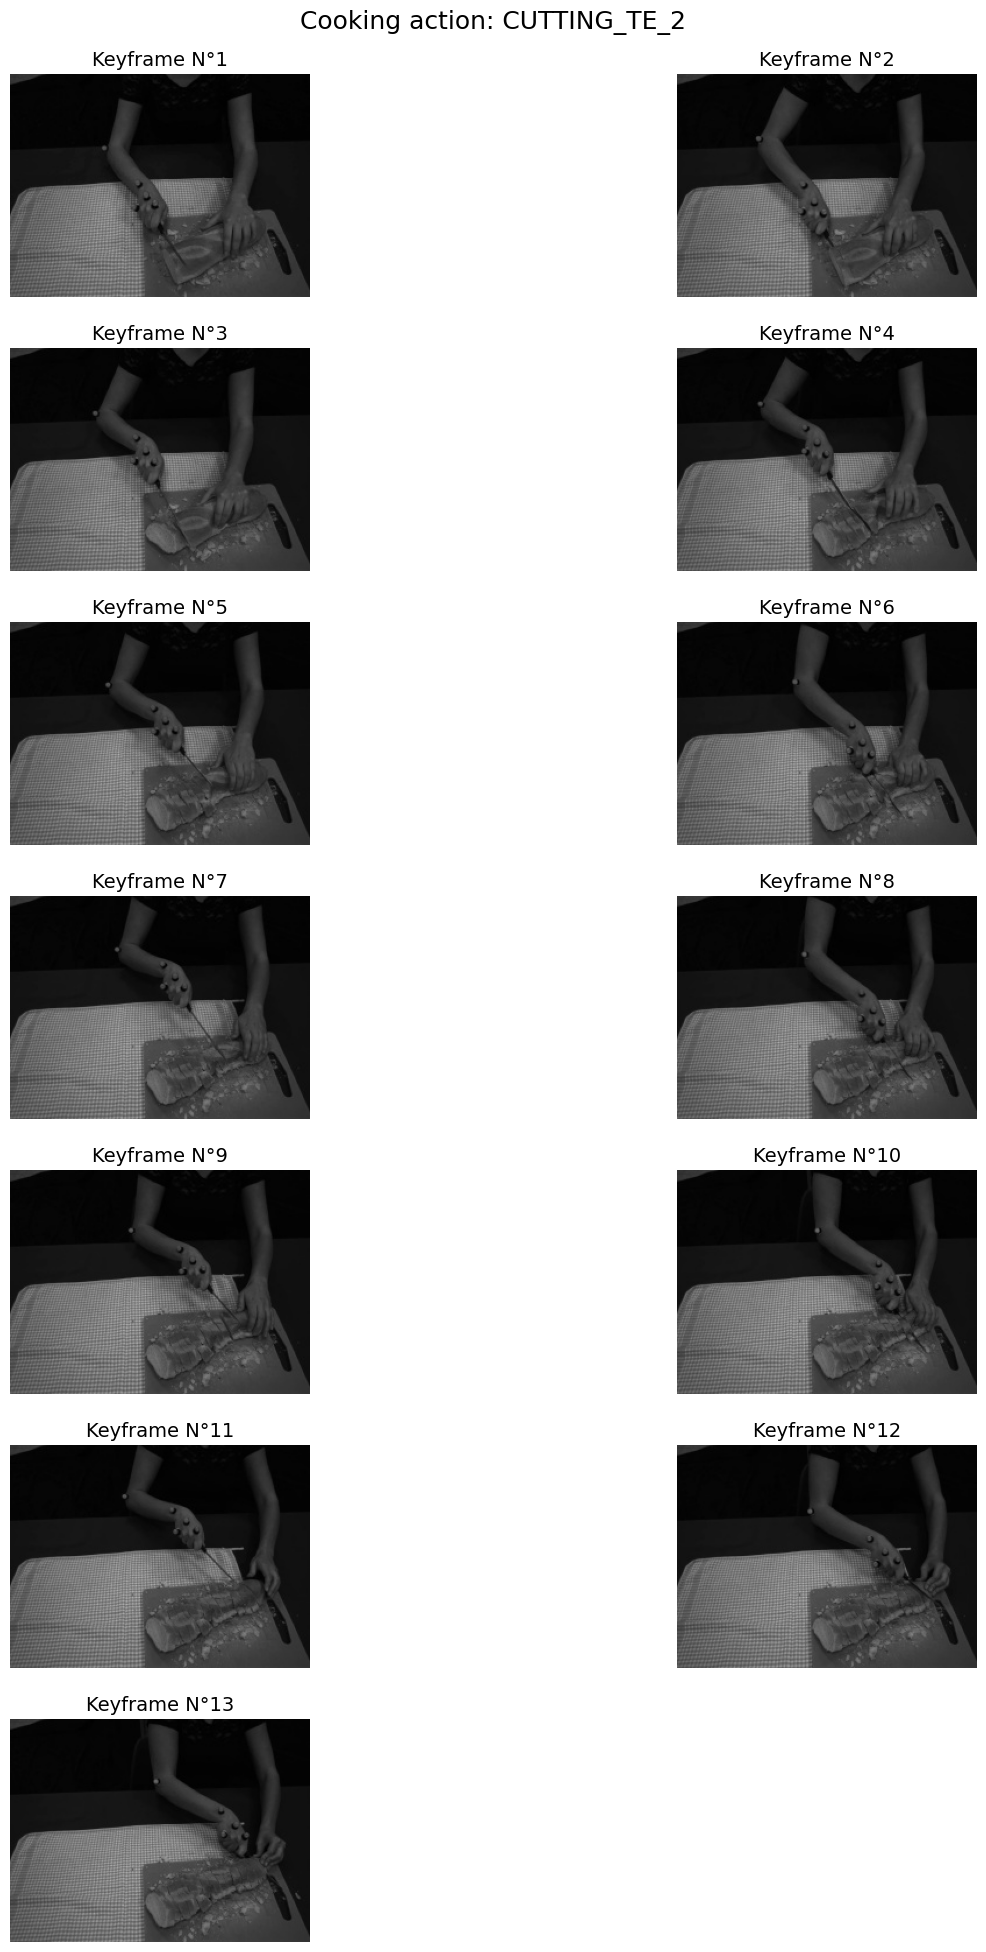

In [12]:
import math
n = 0
for action in actions:

    # create figure
    fig = plt.figure(figsize=(15, 20))
    fig.suptitle("Cooking action: "+action,fontsize=18)

    # setting values to rows and column variables
    rows = math.ceil(NbKFramesList[n]/2)
    columns = 2
    for i in range(1,NbKFramesList[n]+1):
        name = 'keyframes/'+str(action)+'/current_frame' + str(i-1) + '.jpg'
        frame = cv2.imread(name)
        fig.add_subplot(rows, columns, i)
        
        # Displaying the image
        plt.imshow(frame)
        plt.axis("off")
        text = "Keyframe N°"+str(i)
        plt.title(text,fontsize = 14)
    n+=1
    fig.tight_layout(pad=2)
    plt.show()


The results show that our algorithm was able to identify significant frames and simplify the entire cooking action video into a small number of keyframes. When we modify the threshold, the outcomes change. The algorithm functions by identifying those frames as keyframes whenever there is a change (sometimes sudden, sometimes smooth) between frames.